In [1]:
import json

with open("./params.json", mode = "r", encoding = "utf-8") as f:
    data = json.load(f)
    model_path = data["model_path"]
    dataset_path_train = data["dataset_path"]["train"]
    dataset_path_test = data["dataset_path"]["test"]
    num_single_sample_timesteps = data["num_single_sample_timesteps"]
    input_window_length = data["input_window_length"]
    label_window_length = data["label_window_length"]
    input_features = data["input_features"]
    label_features = data["label_features"]

    # Usually window_stride = 1 since we want to check each input window
    window_stride = 20
    seed_val = 0

In [2]:
import torch
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

In [3]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from utils.pipeline.Model import TimeSeriesHuggingFaceTransformer
from utils.pipeline.Data import get_mean_std, WindowedIterableDataset
from utils.pipeline.Run import autoregress

/users/labnet5/gr5/abahari/Documents/Thesis/src/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# class PositionalEncoding(torch.nn.Module):
#     def __init__(self, d_model, dropout, max_len):
#         super().__init__()
#         self.dropout = torch.nn.Dropout(dropout)
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         self.register_buffer("pe", pe.unsqueeze(0))

#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1), :]
#         return self.dropout(x)

In [5]:
# from transformers import T5Config, T5ForConditionalGeneration

# class TimeSeriesHuggingFaceTransformer(T5ForConditionalGeneration):
#     def __init__(self, input_dim, output_dim, d_model, num_head, num_encoder_layers, num_decoder_layers, position_wise_ffn_dim, dropout):
#         # batch_first = True in all huggingface models
#         config = T5Config(
#             vocab_size = 1, # No vocab --> = 1 is placeholder
#             d_model = d_model,
#             num_heads = num_head,
#             num_layers = num_encoder_layers,
#             num_decoder_layers = num_decoder_layers,
#             d_ff = position_wise_ffn_dim,
#             dropout = dropout,
#             decoder_start_token_id = 0,
#             tie_word_embeddings = False,
#             relative_attention_num_buckets = 32, 
#             d_kv = d_model // num_head,

#             output_attention = True    # To get multi-head attentions (num_attention_head values each)
#         )
        
#         super().__init__(config)    # Creates model with random weights

#         self.encoder.embed_tokens = torch.nn.Linear(input_dim, d_model)     # Embedding layer for input
#         self.decoder.embed_tokens = torch.nn.Linear(output_dim, d_model)    # Embedding layer for output
        
#         self.lm_head = torch.nn.Linear(d_model, output_dim, bias = False)   # Last linear before output
        
#         self.output_dim = output_dim

#         self.bos_token = torch.nn.Parameter(torch.empty(1, 1, output_dim))
#         torch.nn.init.normal_(self.bos_token, mean = 0.0, std = 1.0)

#         self.attention_weights = {
#             "encoder_attention": [],
#             "decoder_attention": [],
#             "cross_attention": []
#         }

#     def forward(self, inputs_embeds, decoder_inputs_embeds, **kwargs):
#         outputs = super().forward(
#             inputs_embeds = inputs_embeds,
#             decoder_inputs_embeds = decoder_inputs_embeds,
#             **kwargs
#         )

#         if(outputs.encoder_attentions):
#             self.attention_weights["encoder_attention"].extend(outputs.encoder_attentions)
            
#         if(outputs.decoder_attentions):
#             self.attention_weights["decoder_attention"].extend(outputs.decoder_attentions)
            
#         if(outputs.cross_attentions):
#             self.attention_weights["cross_attention"].extend(outputs.cross_attentions)    # Encoder-Decoder Attention

#         return outputs

In [6]:
# class WindowedIterableDataset(IterableDataset):
#     def __init__(
#             self,
#             dataset_path,
#             stats,
#             input_features,
#             label_features,
#             num_single_sample_timesteps,
#             stride,
#             input_window_length,
#             chunk_size = 512
#         ):
#         '''
#             input_df & label_df
#                 Type: Numpy
#                 Shape: Number of time-series, Number of time-steps, Number of input features
            
#             input_features & label_features
#                 Type: List

#             multi worker setup can cause problems here!
#             There is a fix though! Assign unique data iteration based on worker info.
#         '''

#         super().__init__()
        
#         self.dataset_path = dataset_path
#         self.input_features = input_features
#         self.label_features = label_features
#         self.num_single_sample_timesteps = num_single_sample_timesteps
#         self.stride = stride
#         self.input_window_length = input_window_length
#         self.chunk_size = chunk_size
#         self.means = stats.select(
#             [col for col in stats.columns if "_mean" in col]
#         ).to_numpy()
#         self.stds = stats.select(
#             [col for col in stats.columns if "_std" in col]
#         ).to_numpy()
#         self.stds[self.stds == 0] = 10 ** -8
    
#     def __iter__(self):
#         df_reader = pl.read_csv_batched(self.dataset_path, batch_size = self.chunk_size)

#         while(True):
#             new_chunk = df_reader.next_batches(1)
#             if(new_chunk is None):
#                 break
            
#             data_chunk = new_chunk[0]
#             data_chunk = (
#                 data_chunk
#                 .drop(["id"])    # No eps or n_0_squared!
#                 .select(
#                     pl.col("*").str.json_decode()
#                 )
#                 # .with_columns(
#                 #     eta_list = pl.col("eta_list").list.eval(pl.element().flatten(), parallel = True)
#                 # )
#             )
#             input_df = data_chunk.select(self.input_features).explode("*").to_numpy().reshape(data_chunk.shape[0], self.num_single_sample_timesteps, len(self.input_features))
#             label_df = data_chunk.select(self.label_features).explode("*").to_numpy().reshape(data_chunk.shape[0], self.num_single_sample_timesteps, len(self.label_features))

#             # Permutation substitutes shuffle=True in Dataloader!
#             for time_series_idx in np.random.permutation(data_chunk.shape[0]):
#                 for input_window_start_idx in range(0, self.num_single_sample_timesteps - self.input_window_length, self.stride):
#                     label_window_start_idx = input_window_start_idx + self.input_window_length
                    
#                     input_window = input_df[time_series_idx, input_window_start_idx: label_window_start_idx, :]
#                     label_window = label_df[time_series_idx, label_window_start_idx: label_window_start_idx + label_window_length, :]
#                     input_labels = label_df[time_series_idx, input_window_start_idx:, :]

#                     input_window = (input_window - self.means) / self.stds
#                     label_window = (label_window - self.means) / self.stds
#                     input_labels = (input_labels - self.means) / self.stds

#                     input_window = torch.tensor(input_window, dtype = torch.float)
#                     label_window = torch.tensor(label_window, dtype = torch.float)
#                     input_labels = torch.tensor(input_labels, dtype = torch.float)

#                     yield input_window, label_window, input_labels

In [7]:
stats = get_mean_std(
    dataset_path = dataset_path_train,
    cols = input_features
)

df_test = WindowedIterableDataset(
    dataset_path = dataset_path_test,
    stats = stats,
    input_features = input_features,
    label_features = label_features,
    num_single_sample_timesteps = num_single_sample_timesteps,
    stride = window_stride,
    input_window_length = input_window_length,
    label_window_length = label_window_length,
    inference = True
)

data_loader_test = DataLoader(
    df_test,
    batch_size = None,
    pin_memory = True
)

## Prediction

In [8]:
model = torch.load(model_path, weights_only = False).to(device)
model.eval()

TimeSeriesHuggingFaceTransformer(
  (shared): Embedding(1, 64)
  (encoder): T5Stack(
    (embed_tokens): Linear(in_features=5, out_features=64, bias=True)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=64, out_features=64, bias=False)
              (k): Linear(in_features=64, out_features=64, bias=False)
              (v): Linear(in_features=64, out_features=64, bias=False)
              (o): Linear(in_features=64, out_features=64, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=64, out_features=64, bias=False)
              (wo): Linear(in_features=64, out_features=64, bias=False)
              

0it [00:00, ?it/s, single_test_loss=0.005558]

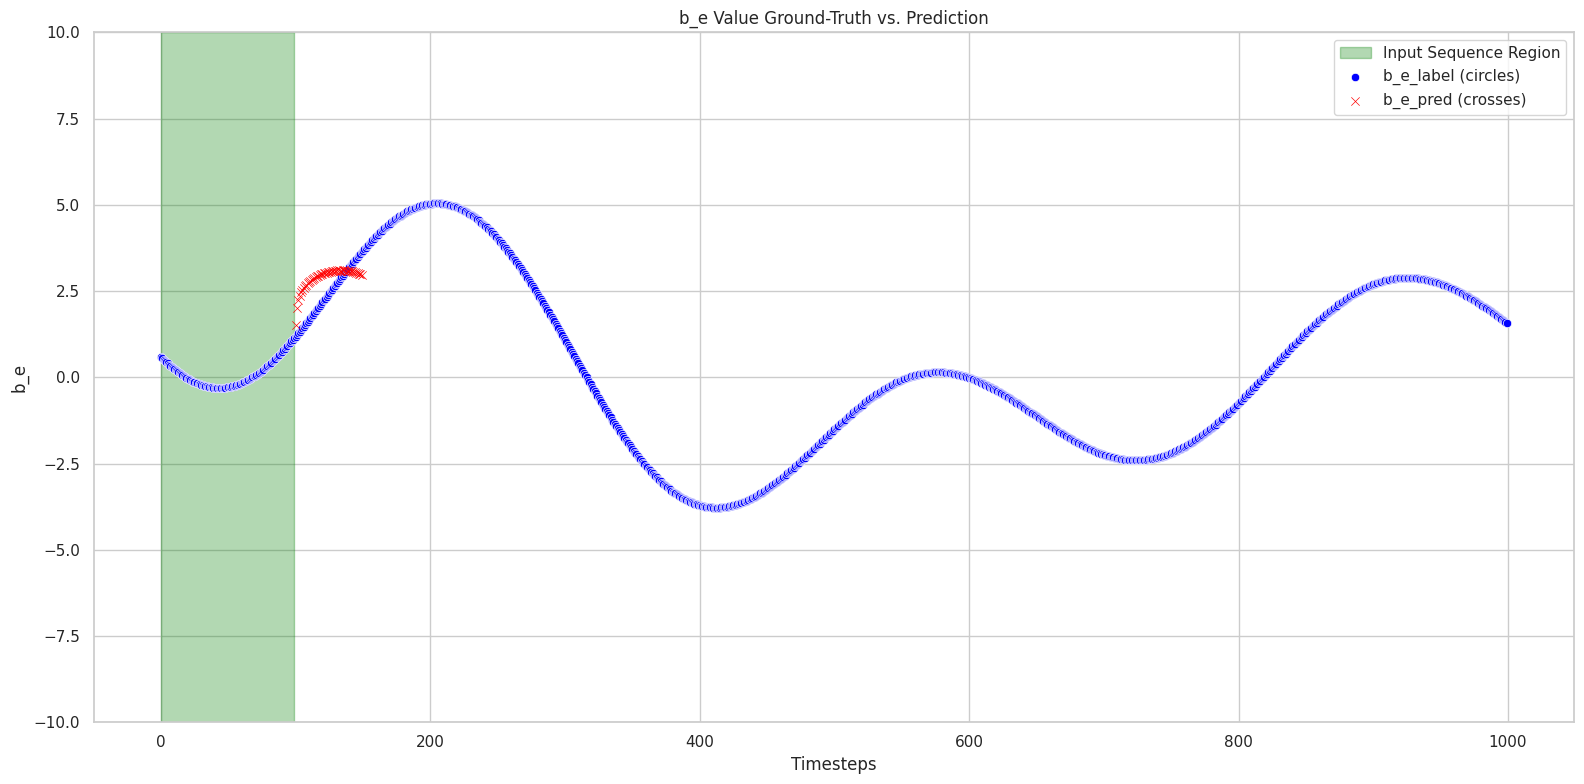

85it [00:00, 187.37it/s, single_test_loss=0.005711]

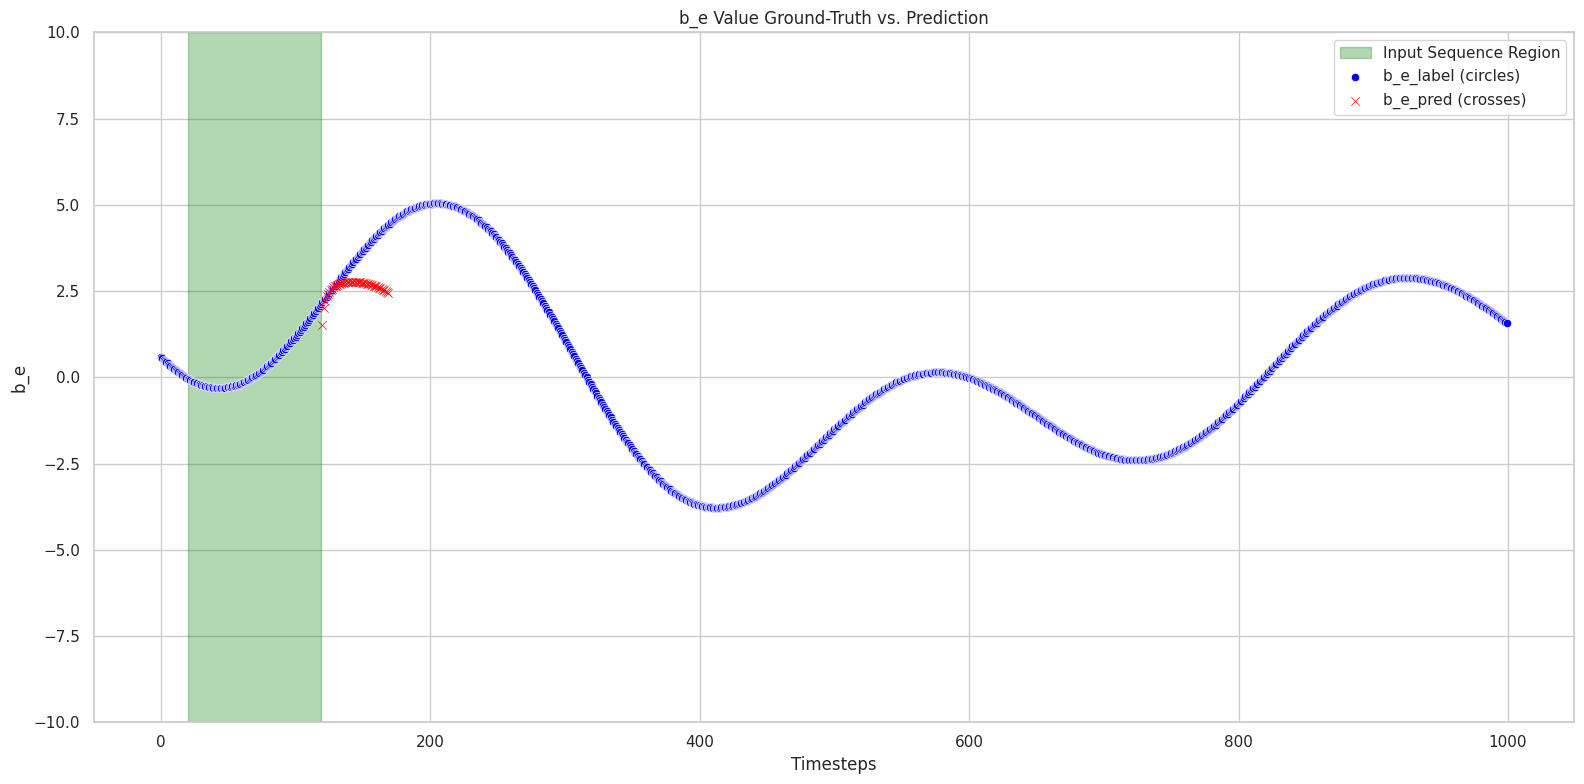

85it [00:00, 187.37it/s, single_test_loss=0.007619]

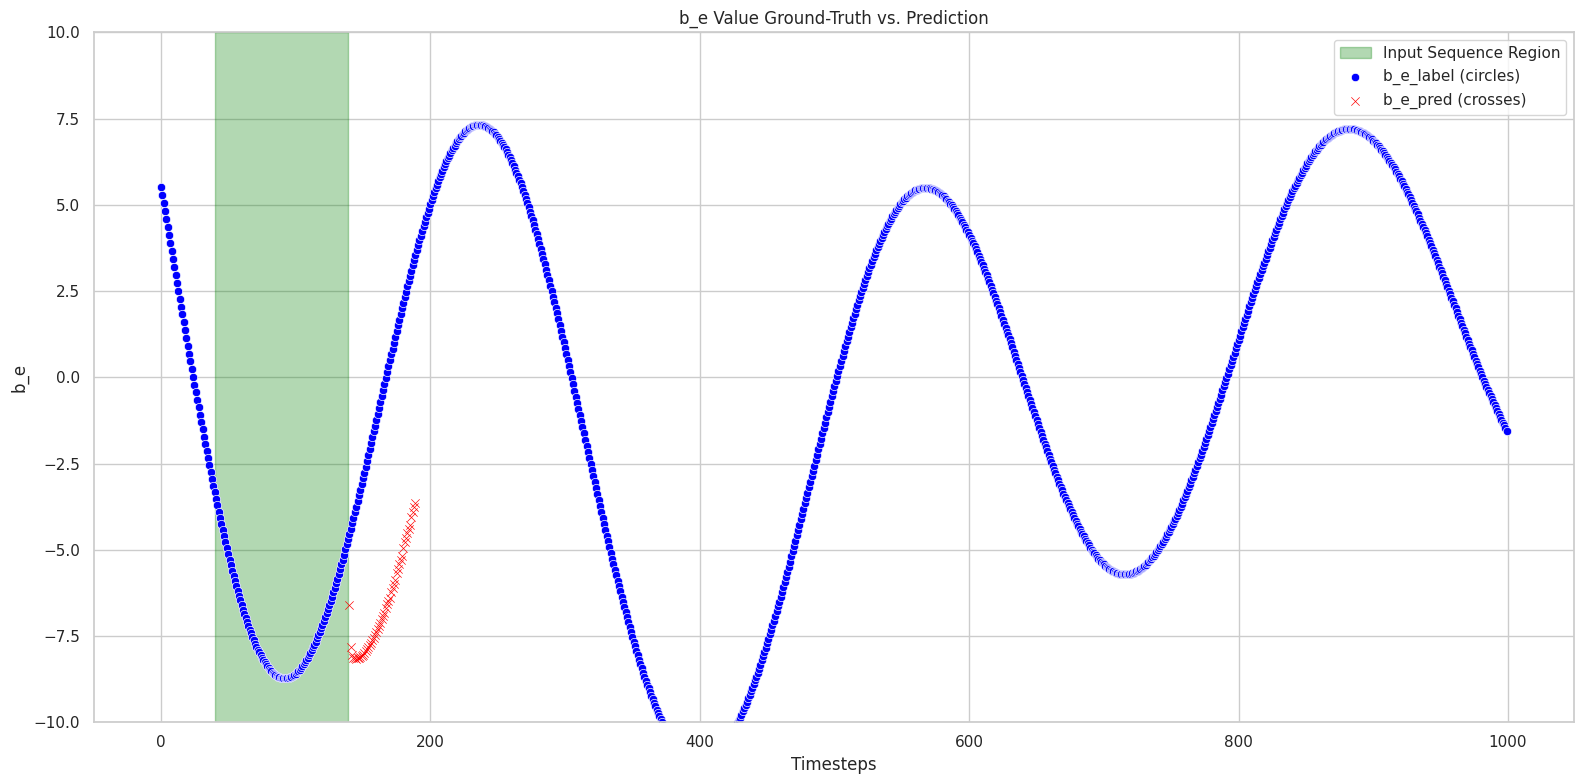

85it [00:00, 187.37it/s, single_test_loss=0.008669]

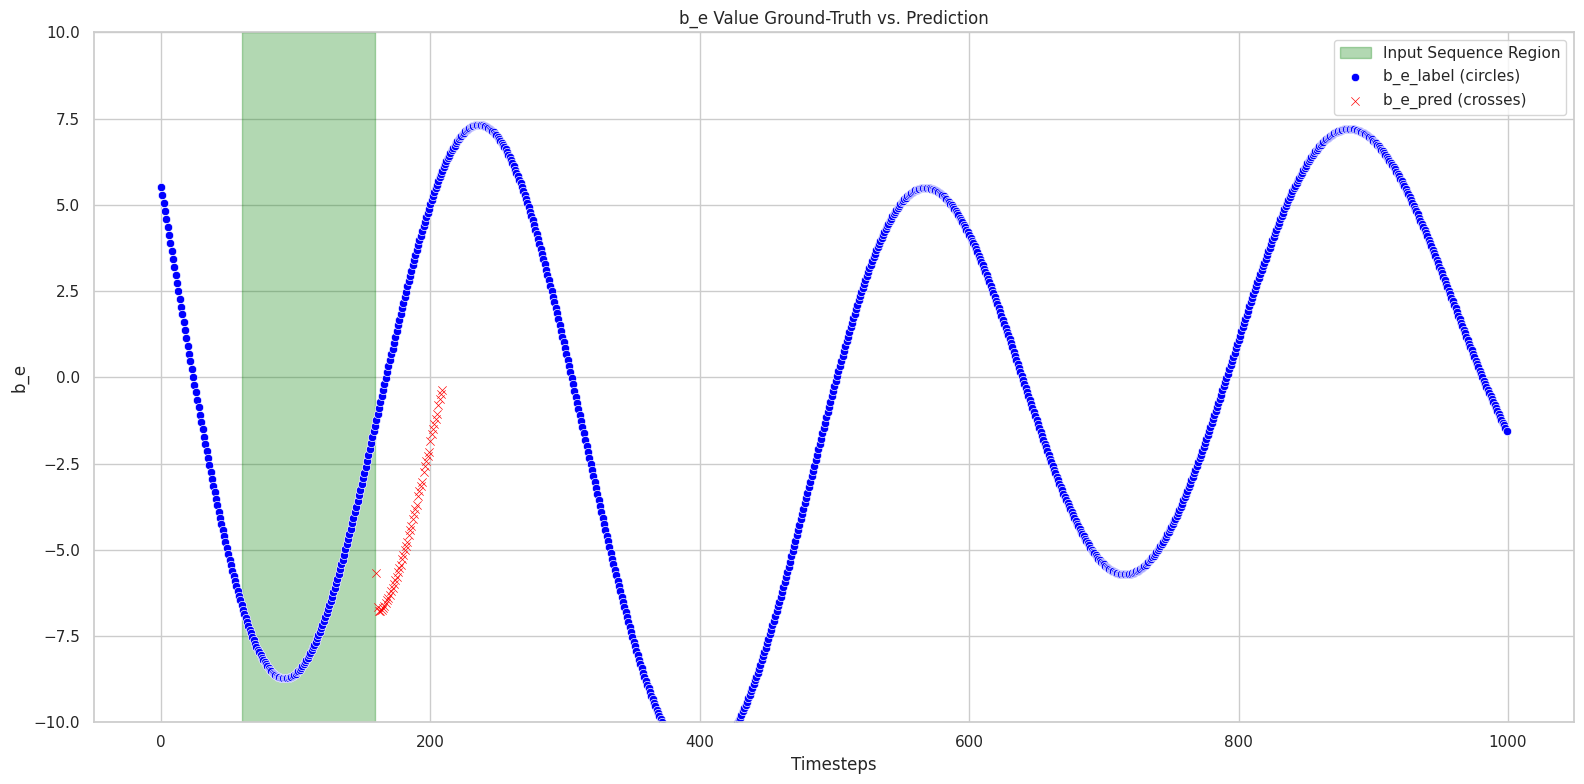

85it [00:01, 187.37it/s, single_test_loss=0.009724]

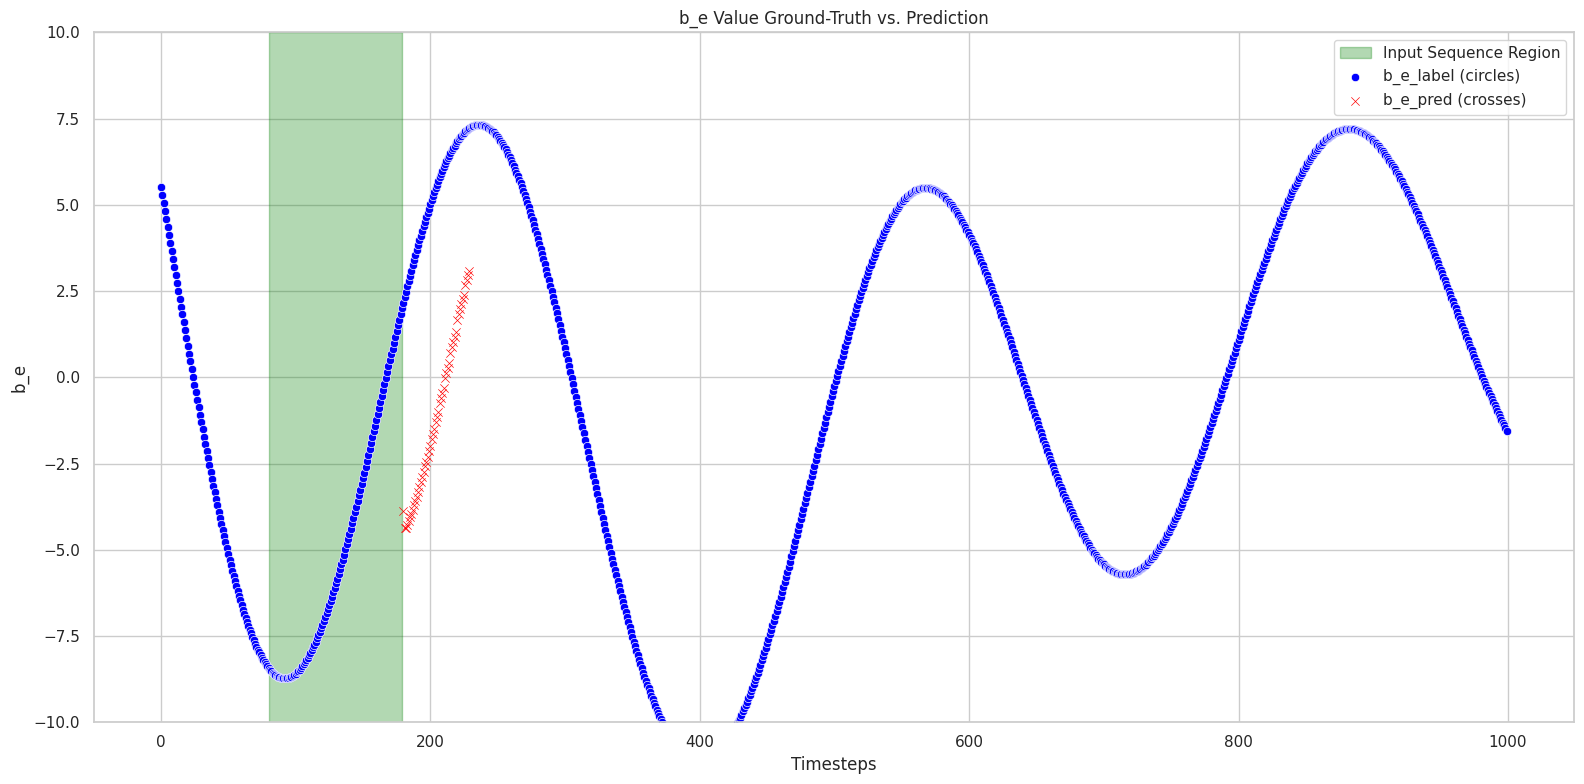

85it [00:01, 187.37it/s, single_test_loss=0.011653]

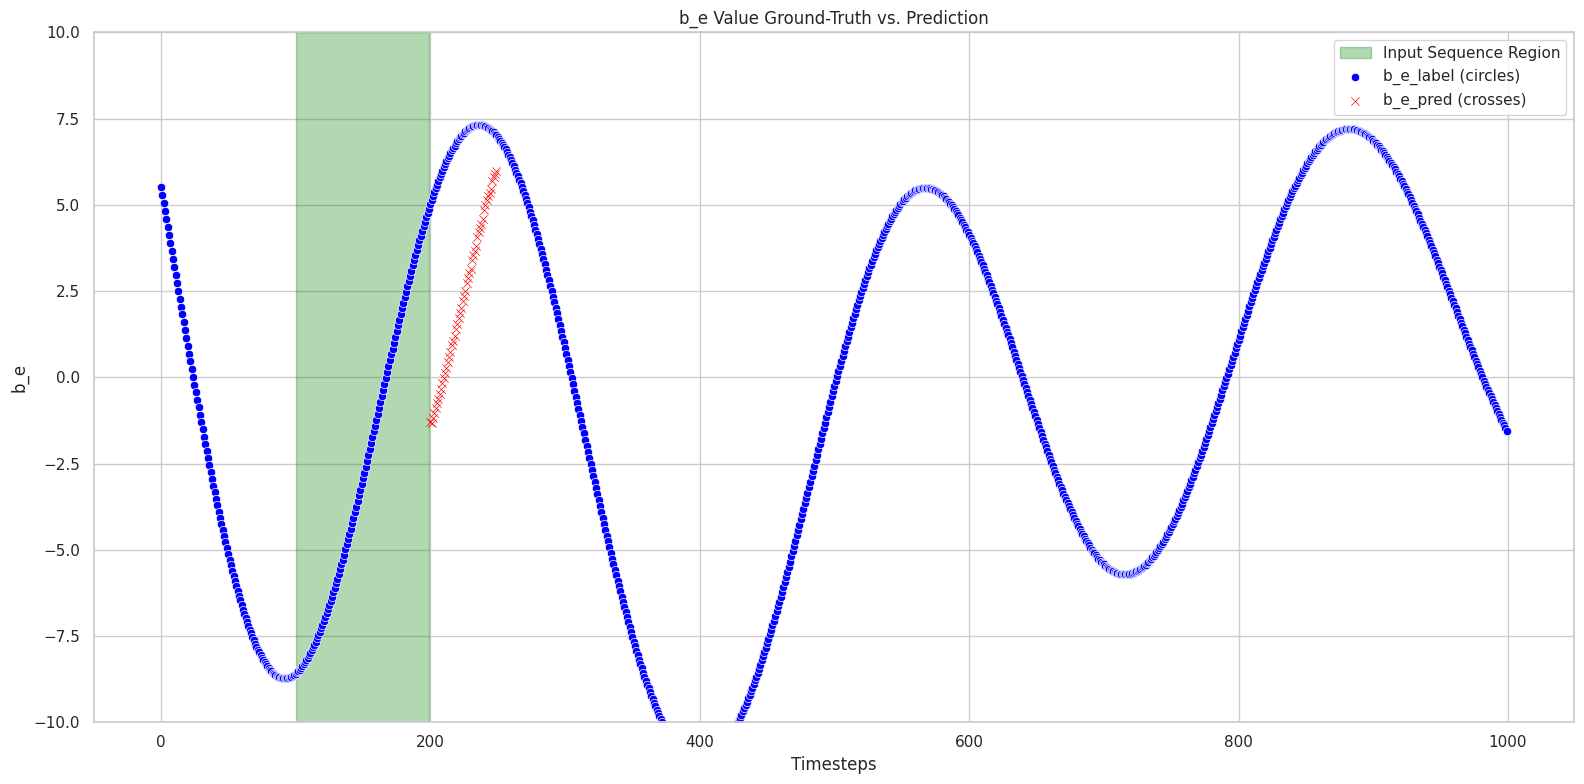

85it [00:01, 187.37it/s, single_test_loss=0.013653]

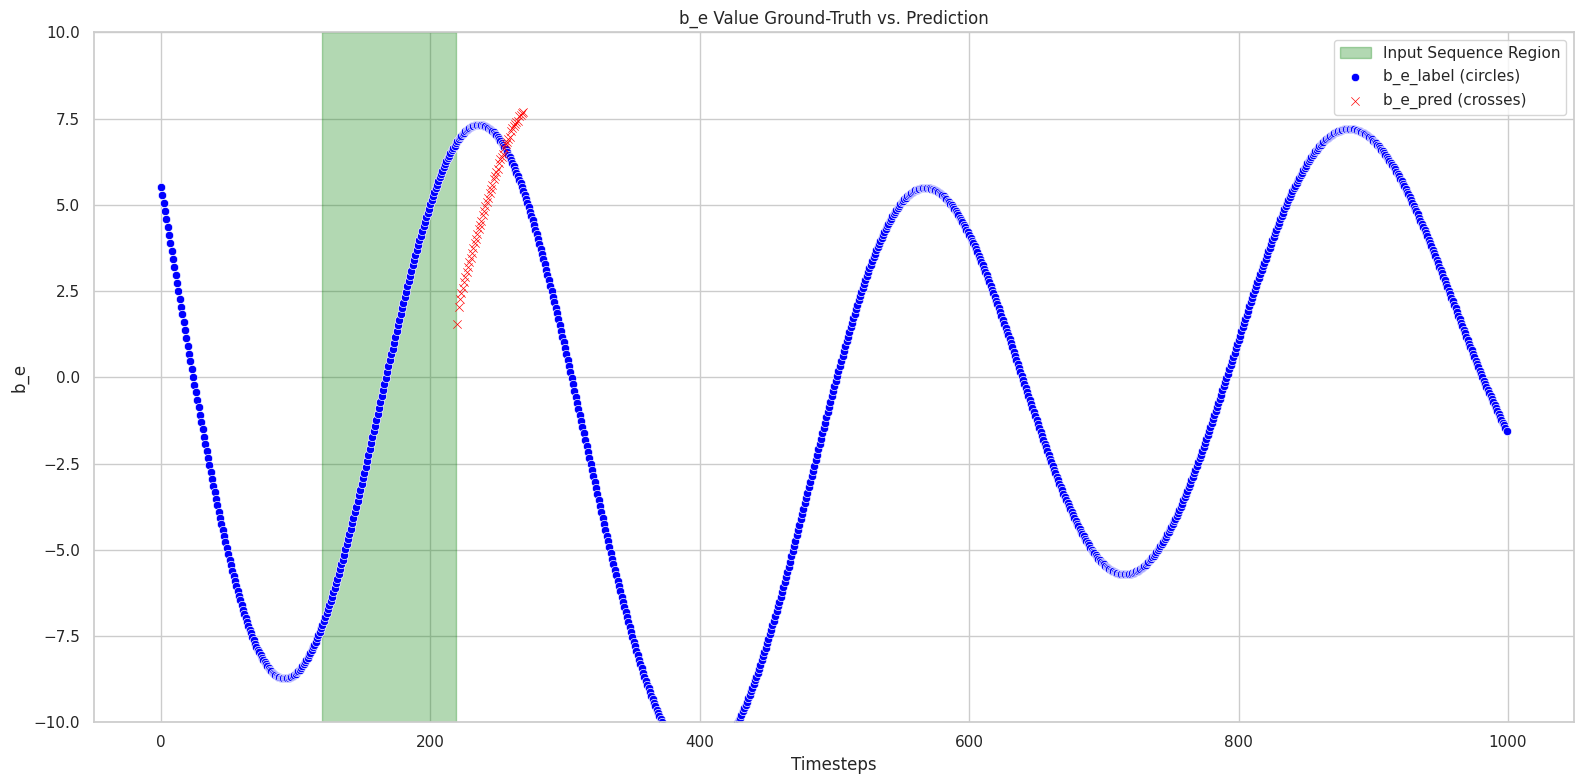

85it [00:01, 187.37it/s, single_test_loss=0.017242]

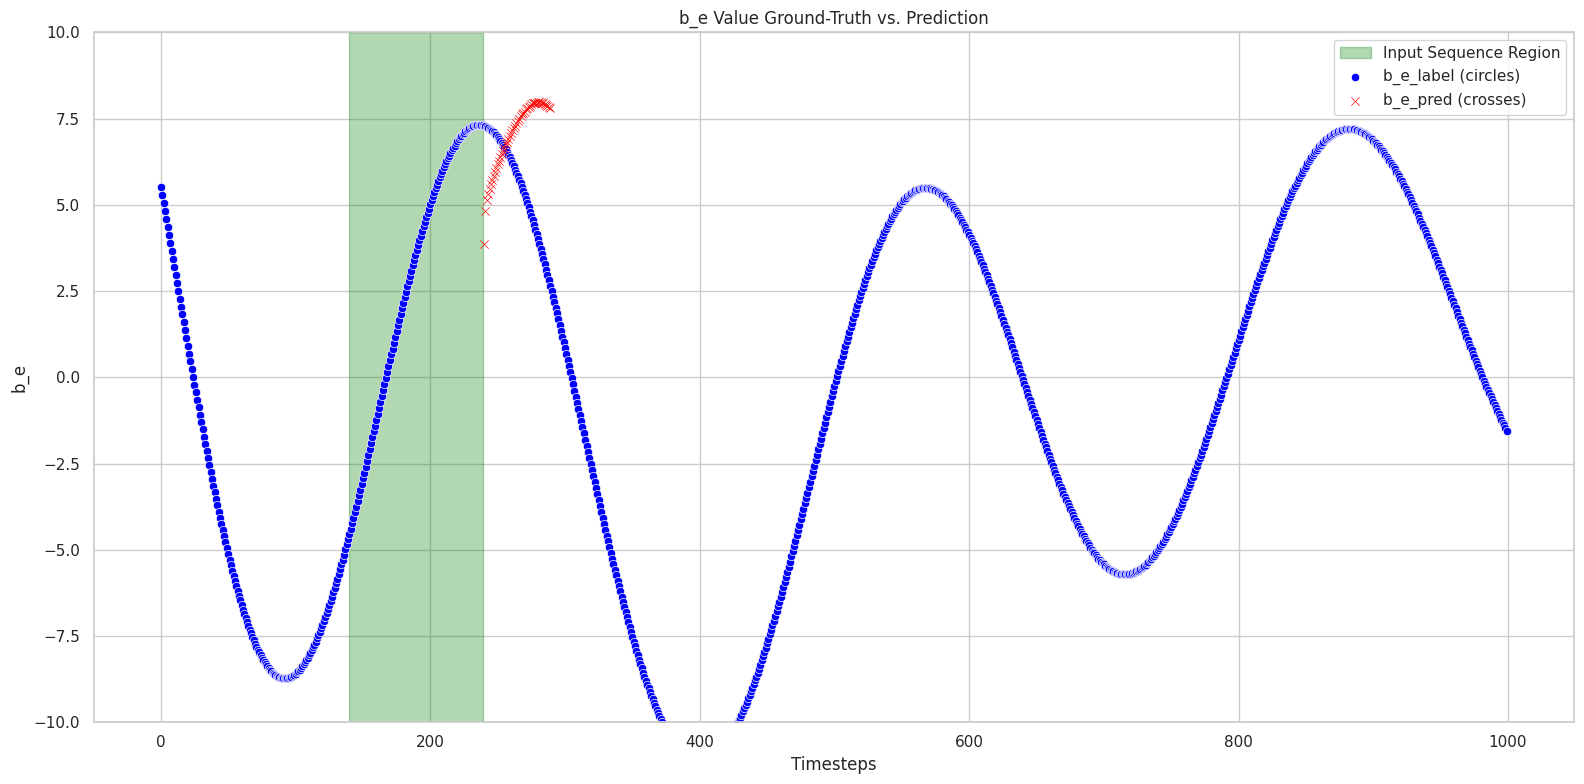

85it [00:02, 187.37it/s, single_test_loss=0.014533]

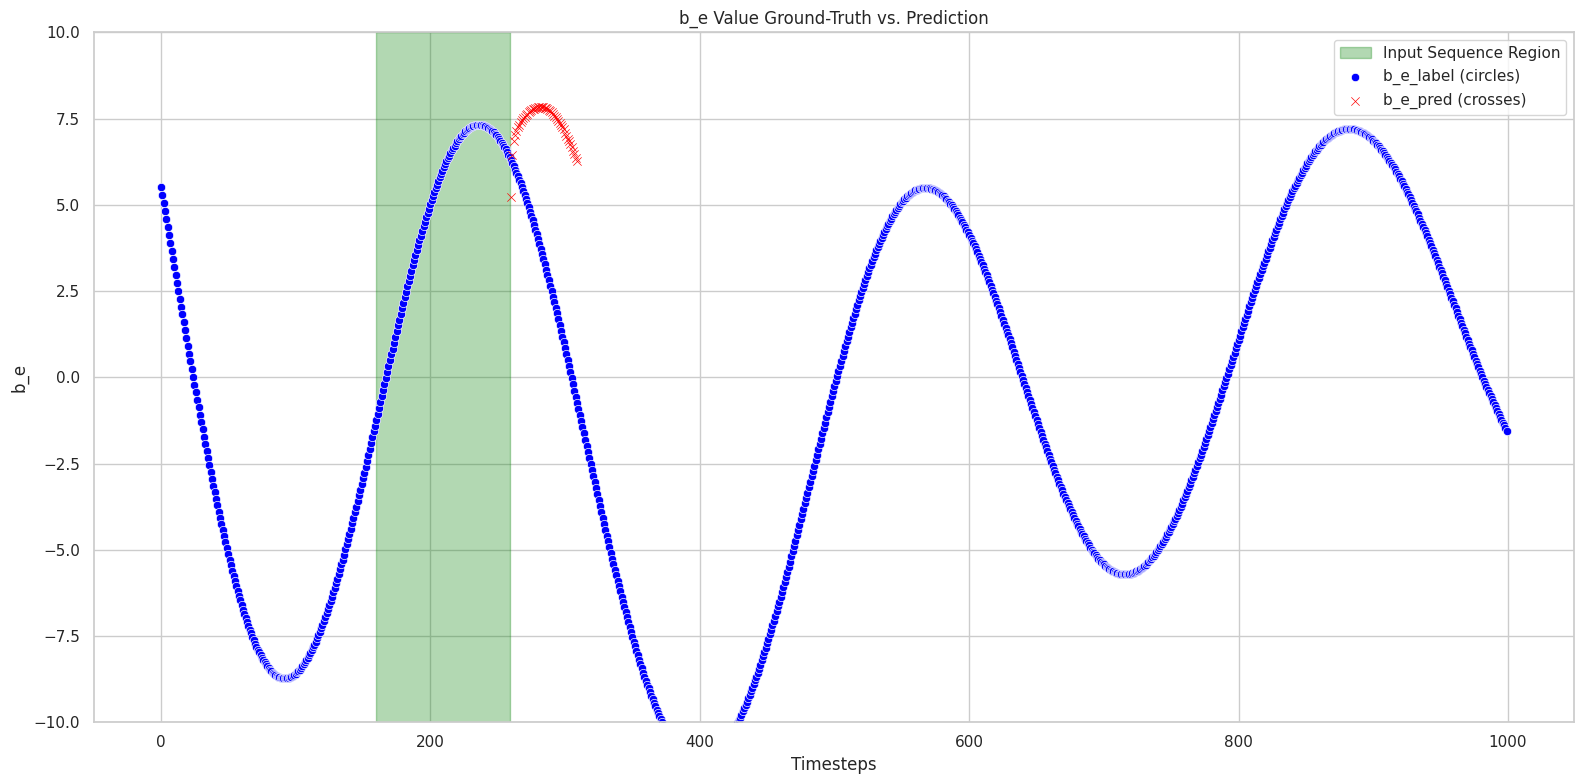

85it [00:02, 187.37it/s, single_test_loss=0.010782]

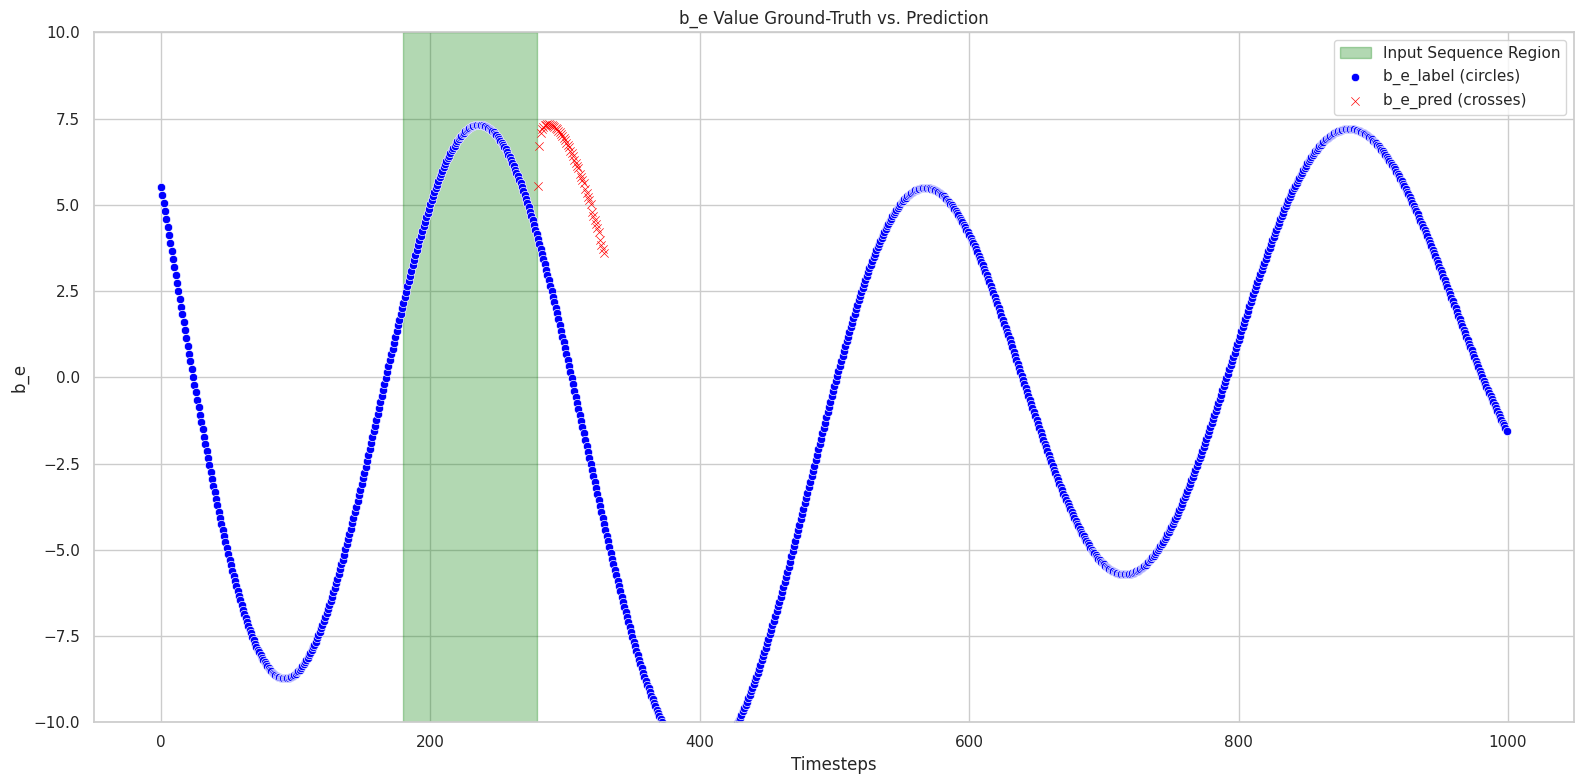

85it [00:02, 187.37it/s, single_test_loss=0.010149]

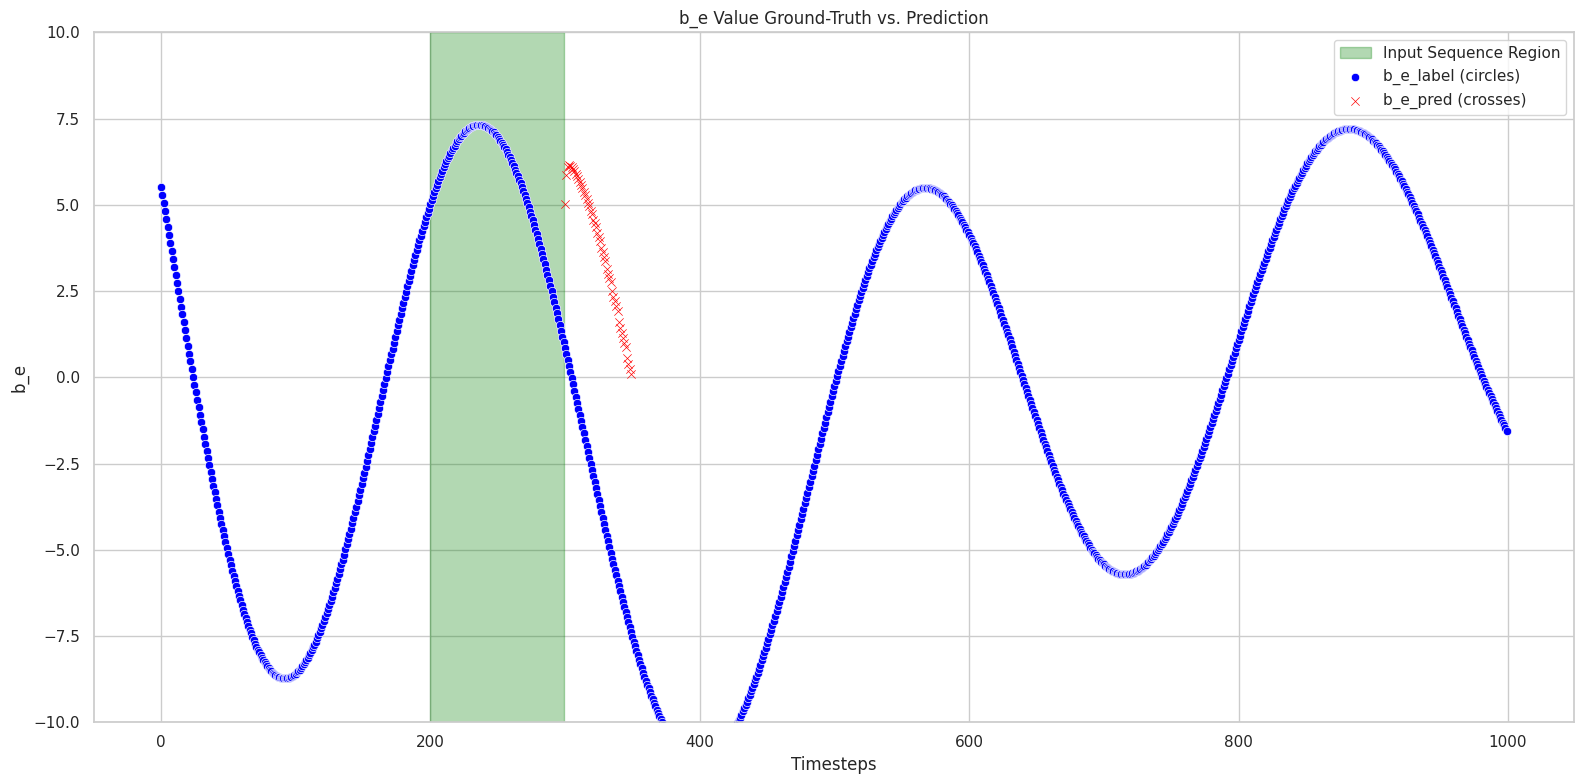

85it [00:02, 187.37it/s, single_test_loss=0.008800]

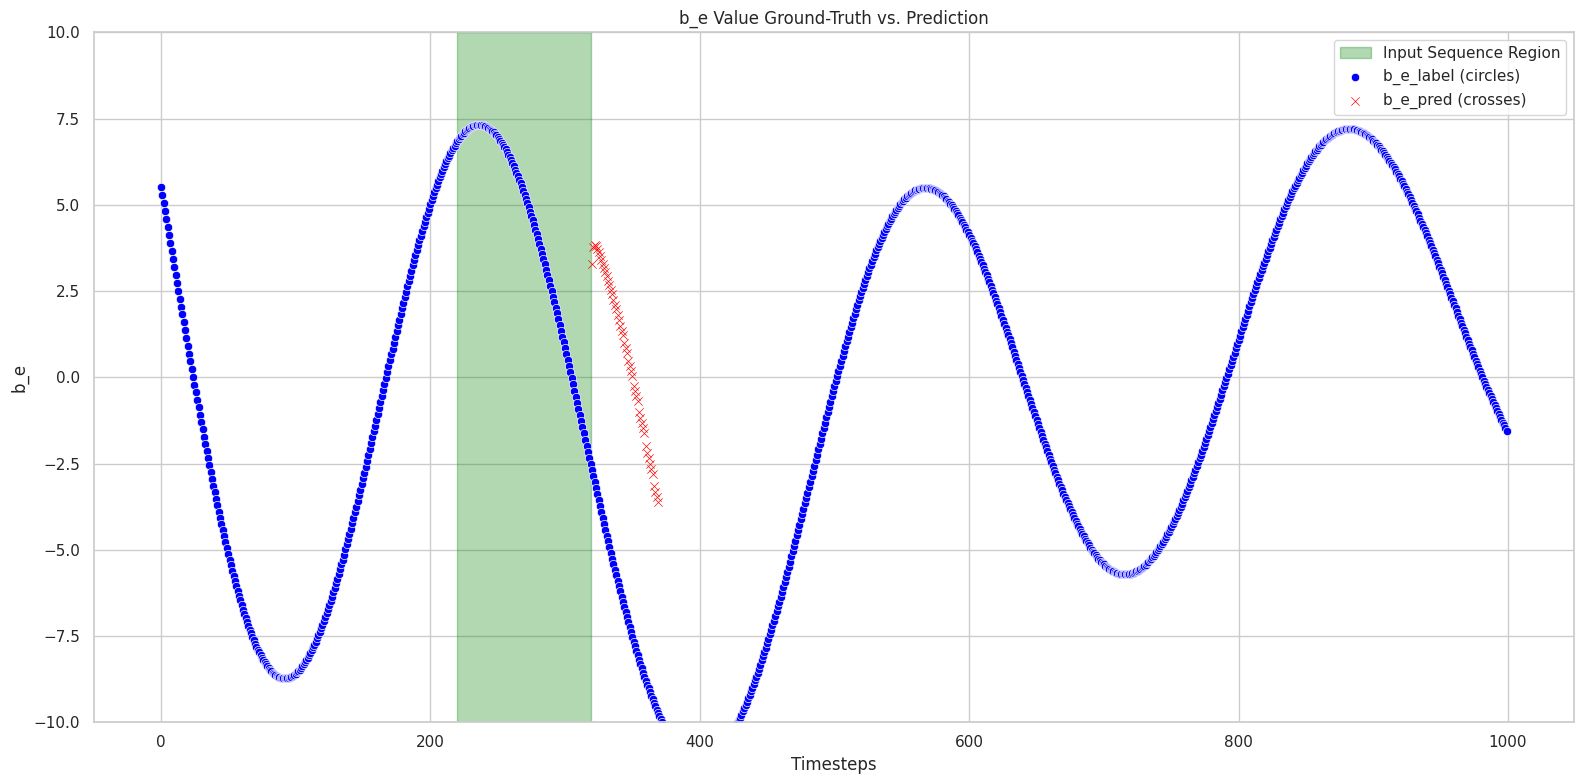

85it [00:03, 187.37it/s, single_test_loss=0.008355]

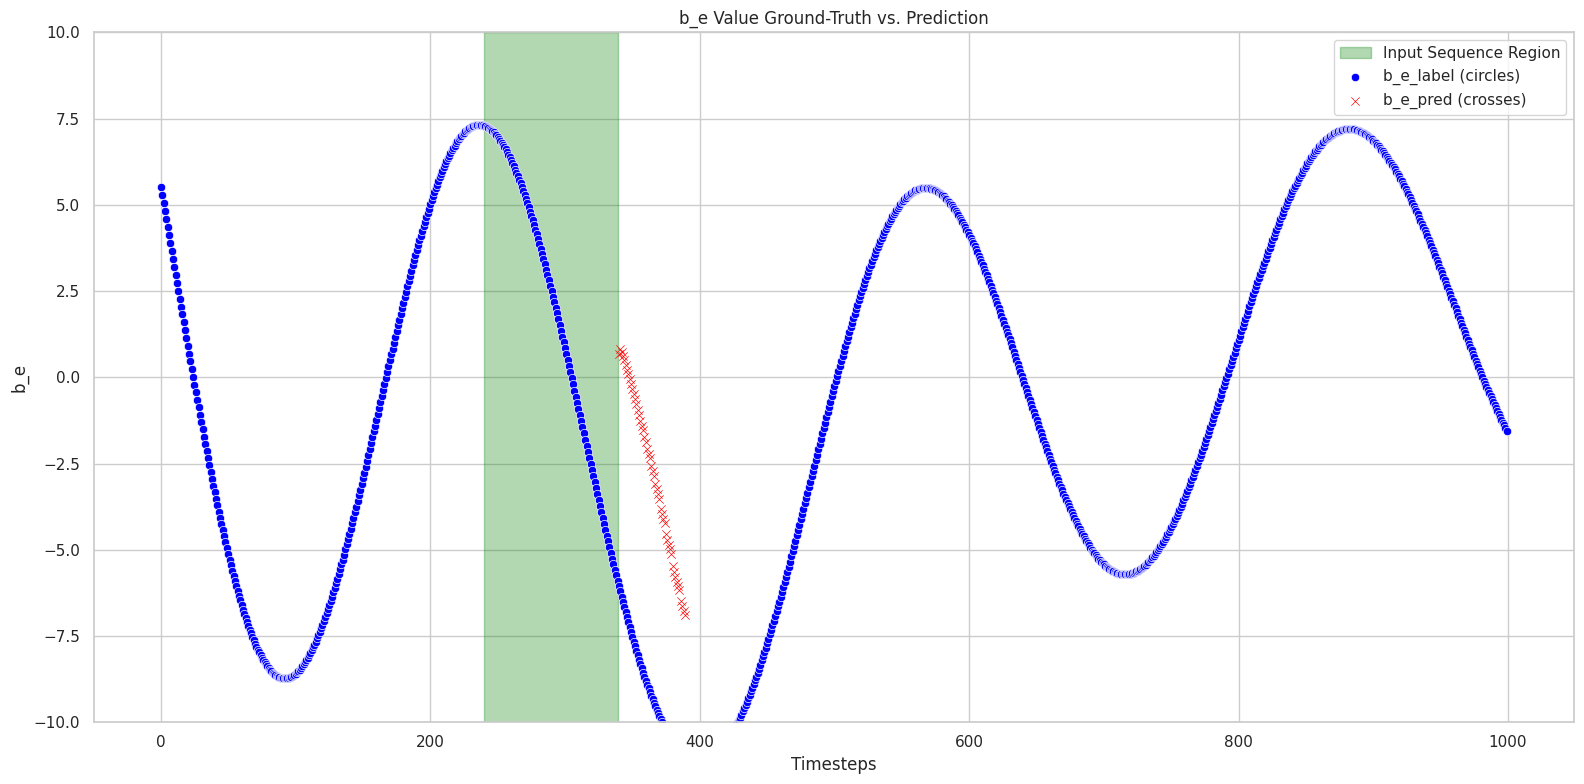

85it [00:03, 187.37it/s, single_test_loss=0.008381]

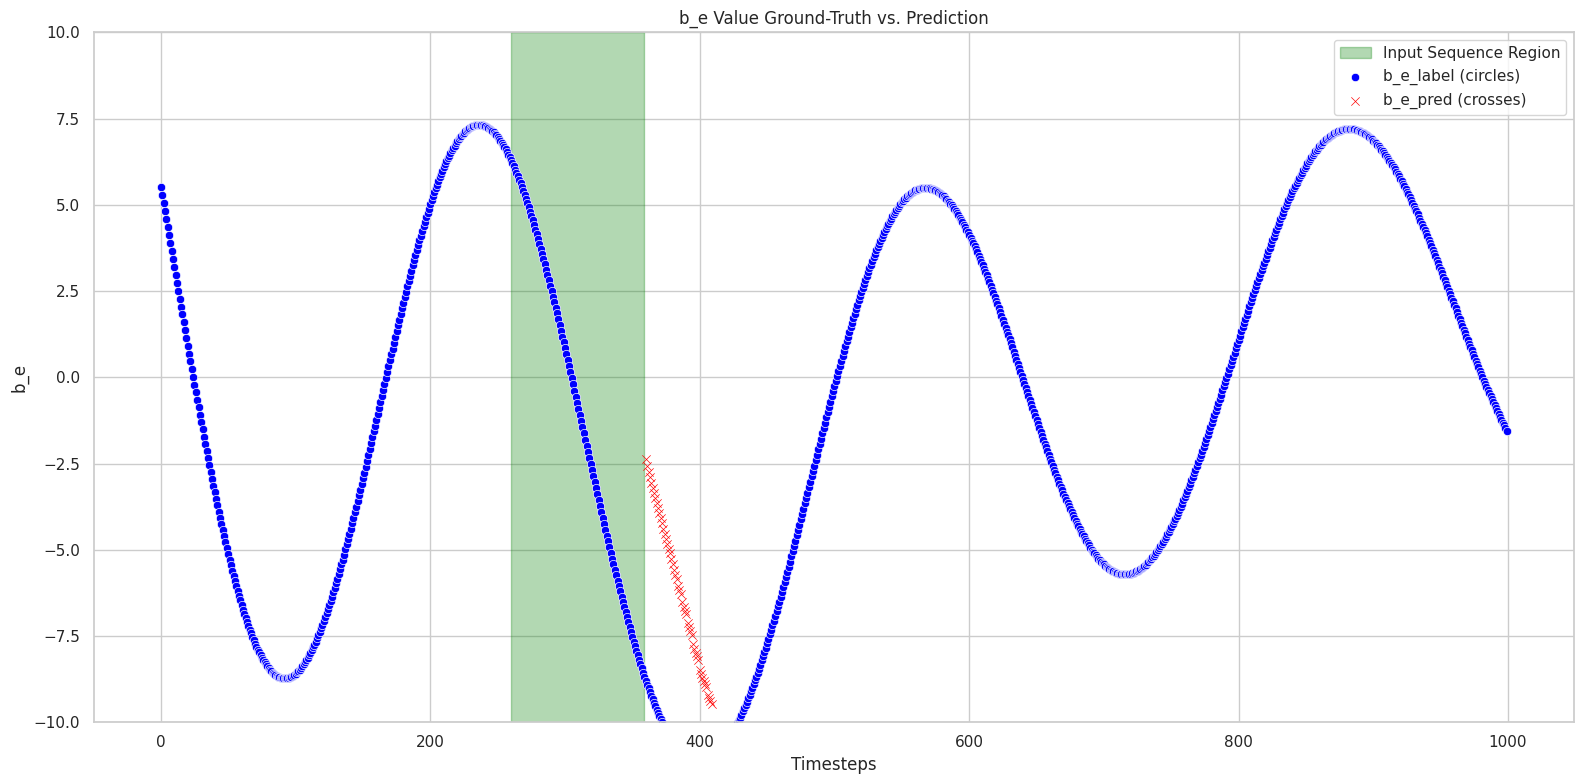

85it [00:03, 187.37it/s, single_test_loss=0.009058]

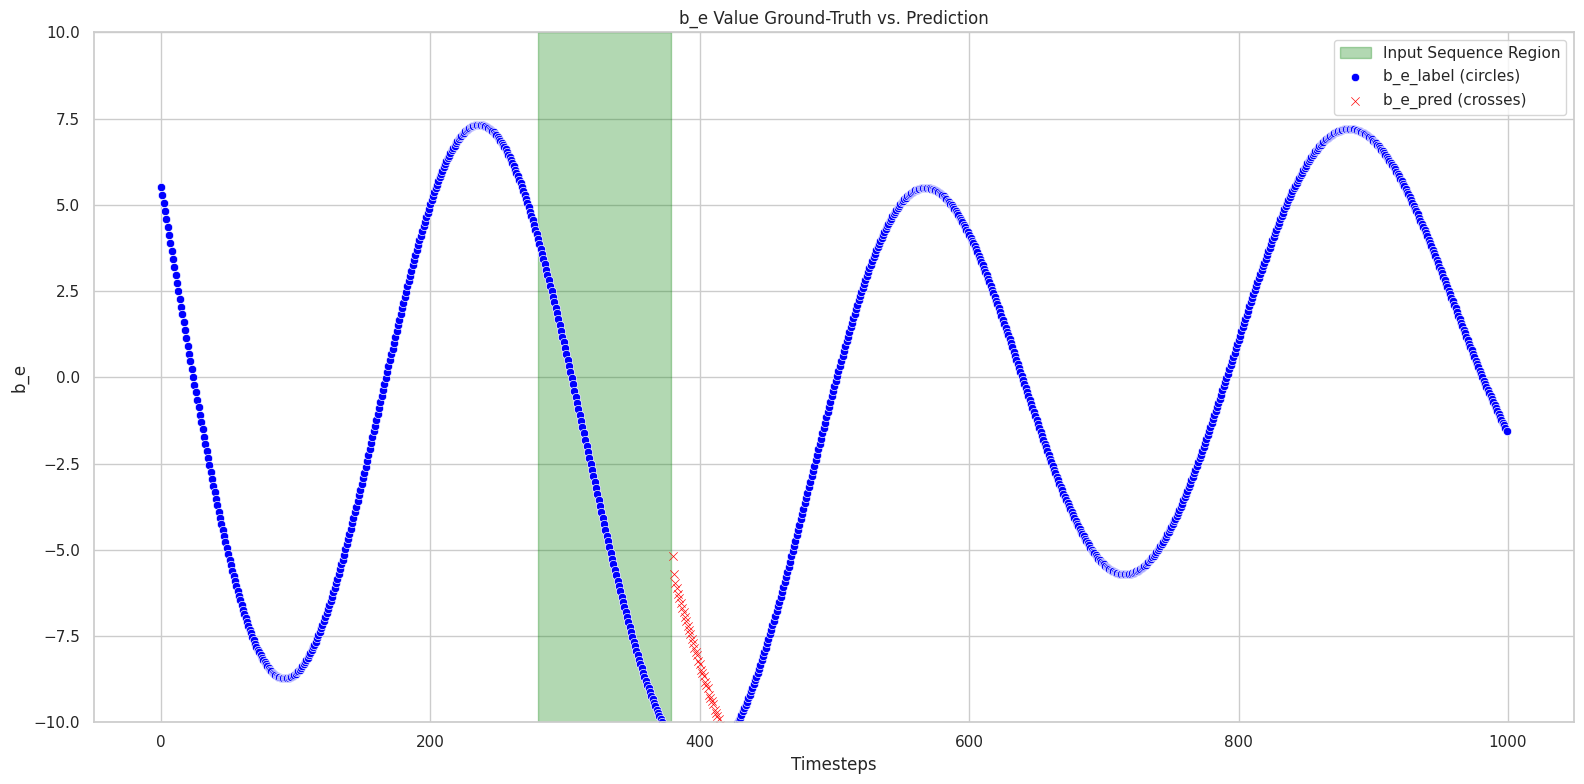

85it [00:03, 187.37it/s, single_test_loss=0.006790]

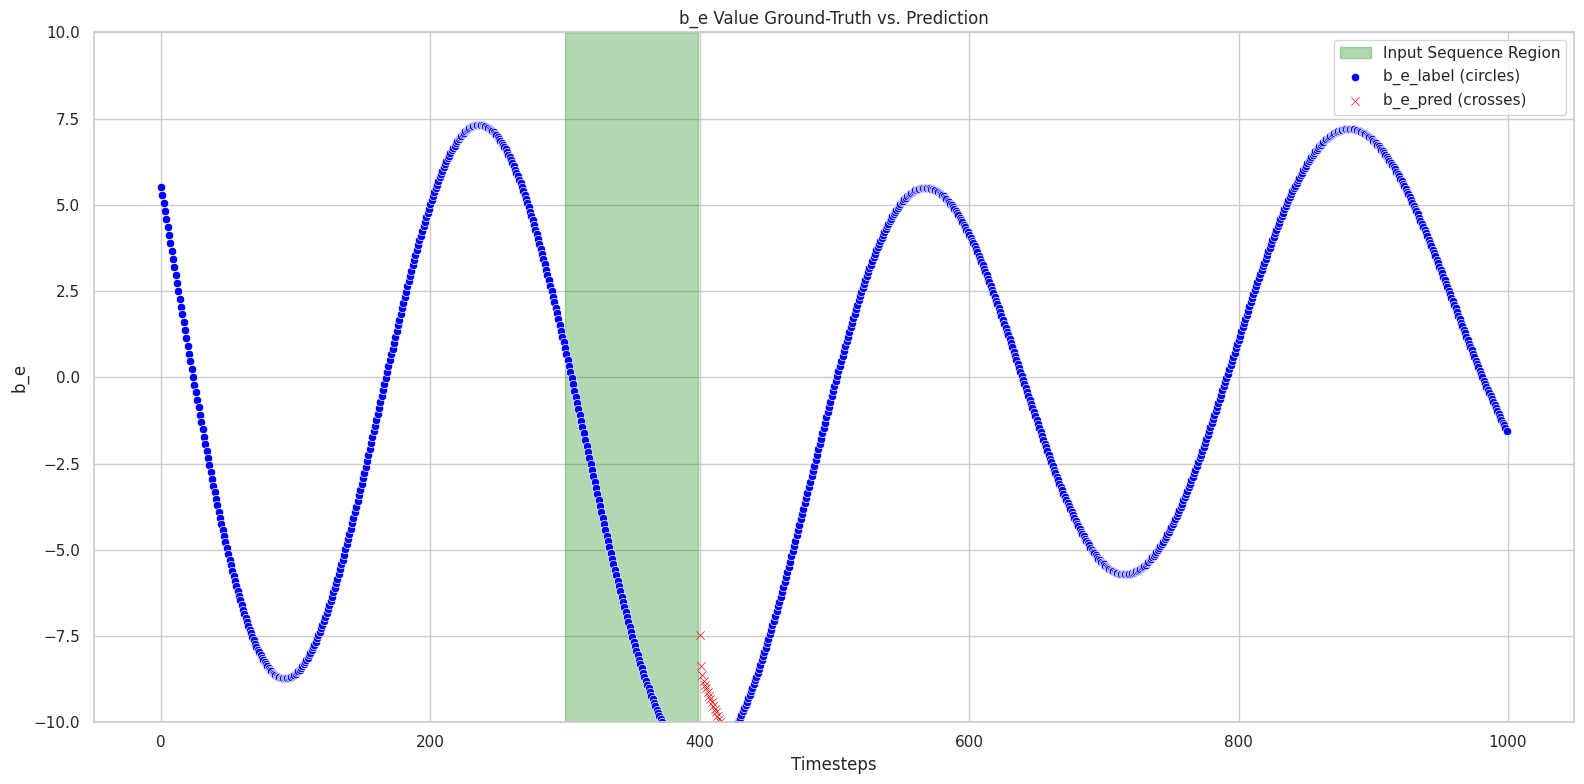

85it [00:03, 187.37it/s, single_test_loss=0.004591]

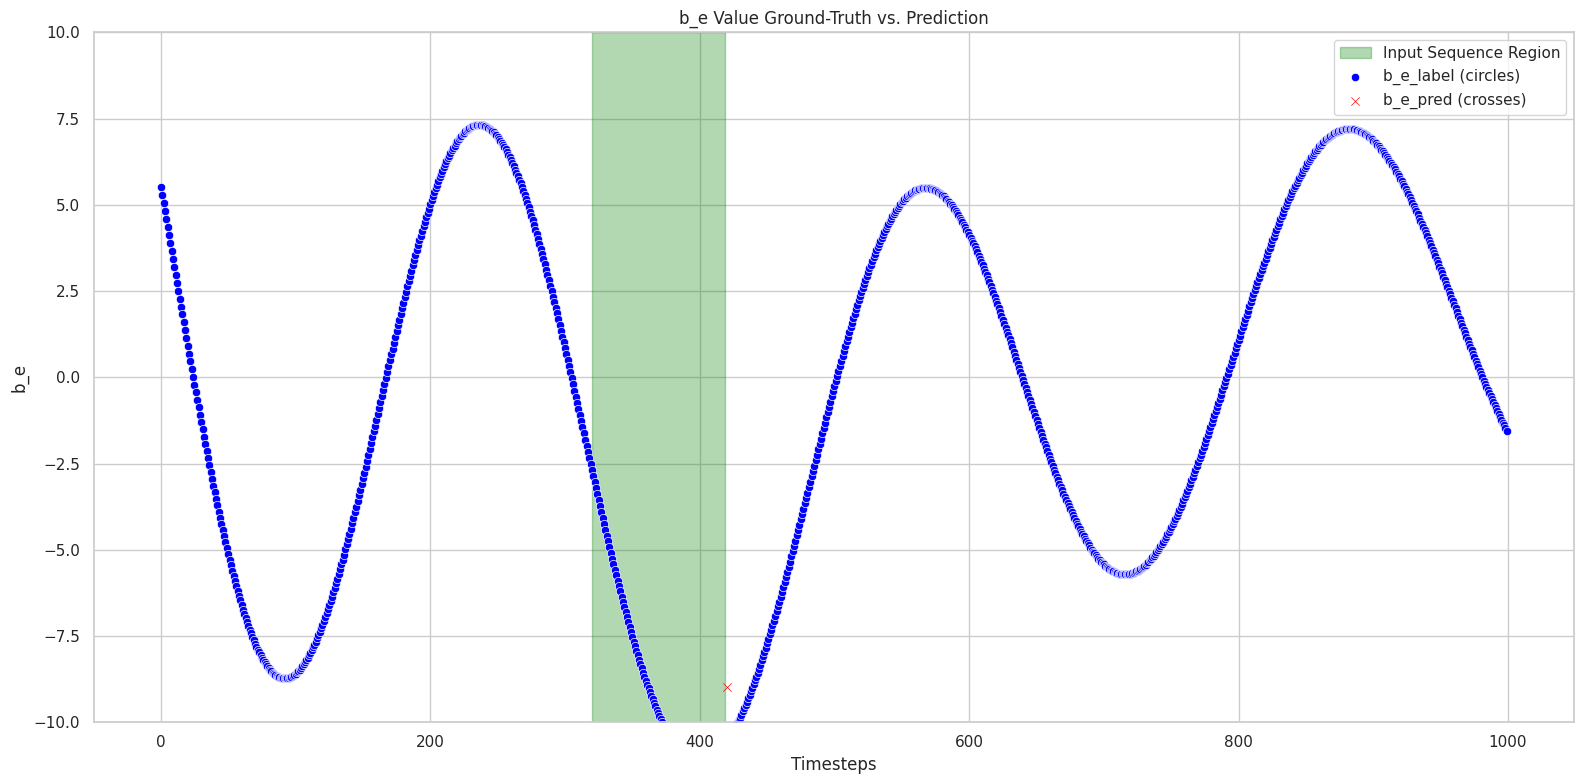

85it [00:04, 187.37it/s, single_test_loss=0.004169]

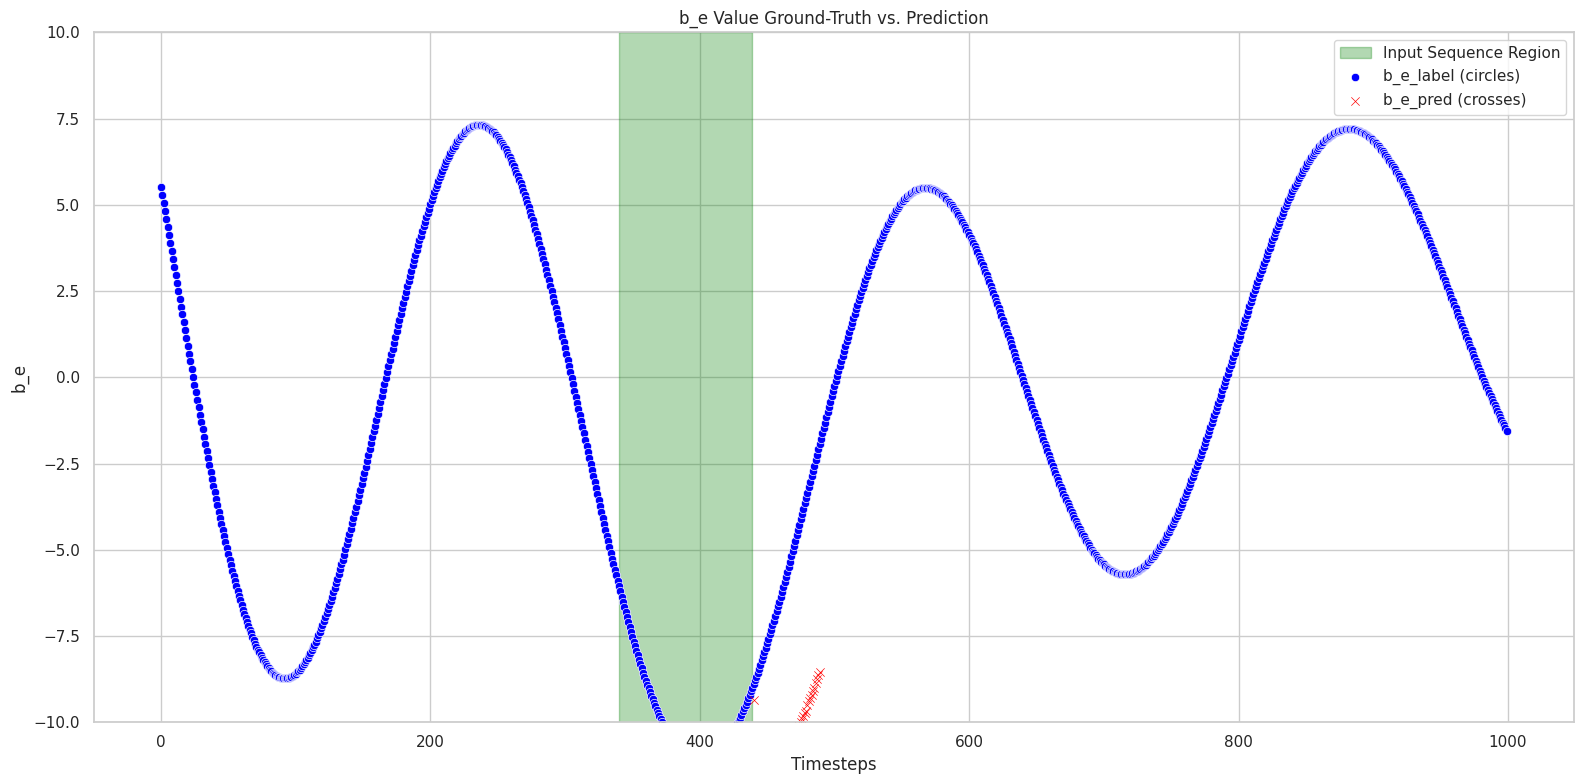

85it [00:04, 187.37it/s, single_test_loss=0.004214]

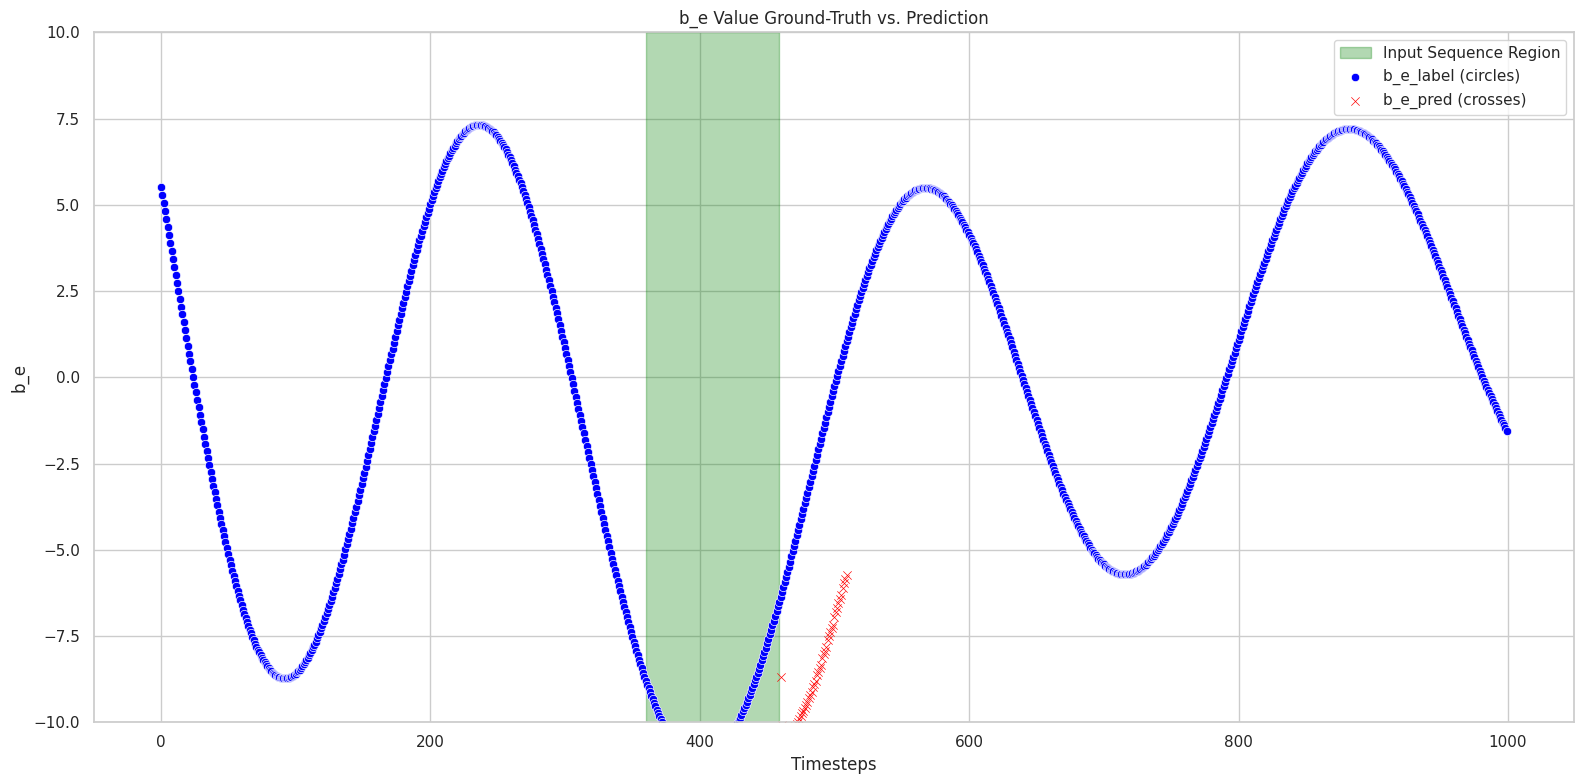

85it [00:04, 187.37it/s, single_test_loss=0.004855]

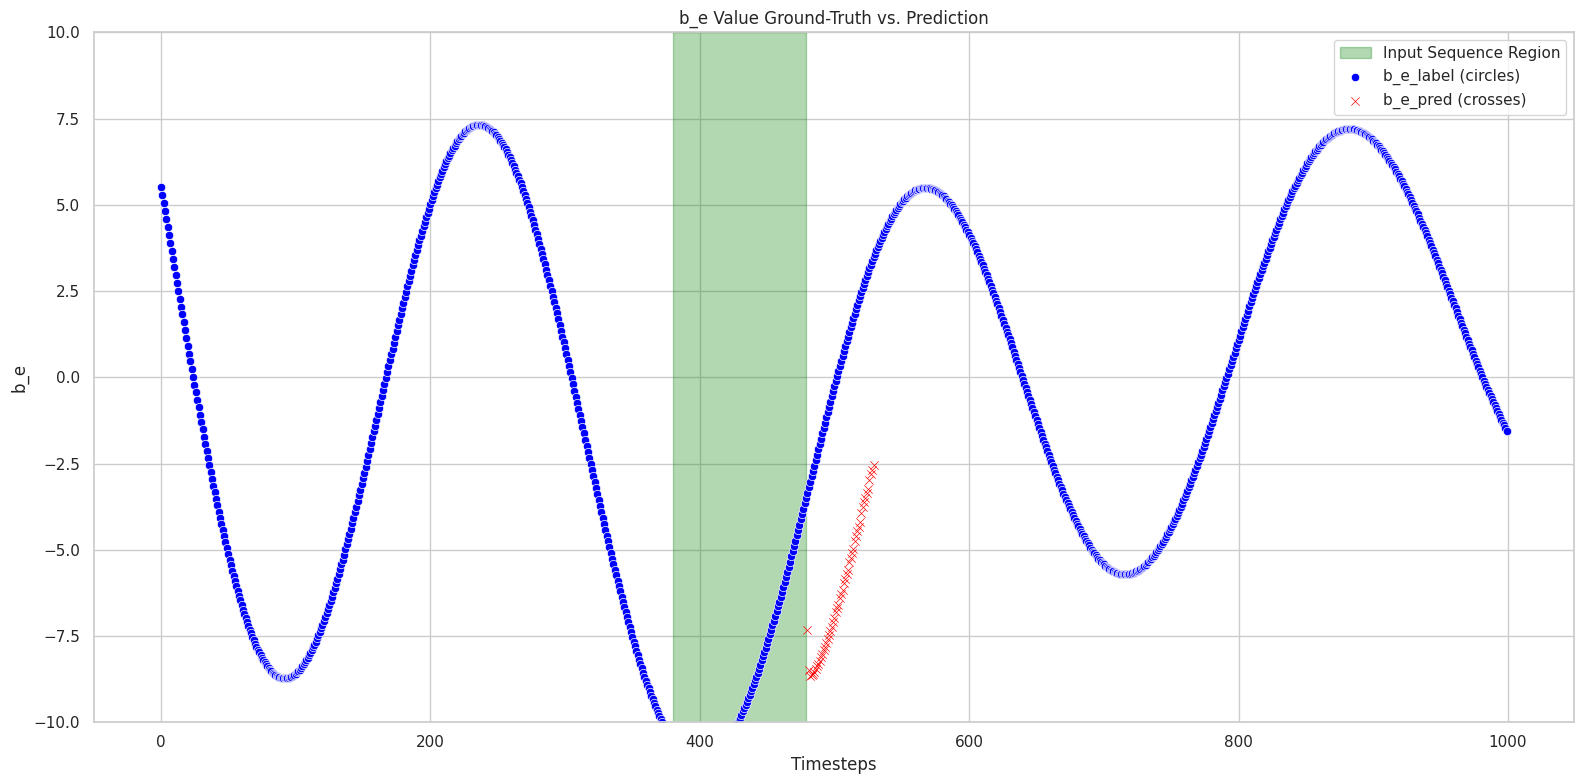

104it [00:04, 16.91it/s, single_test_loss=0.006000]

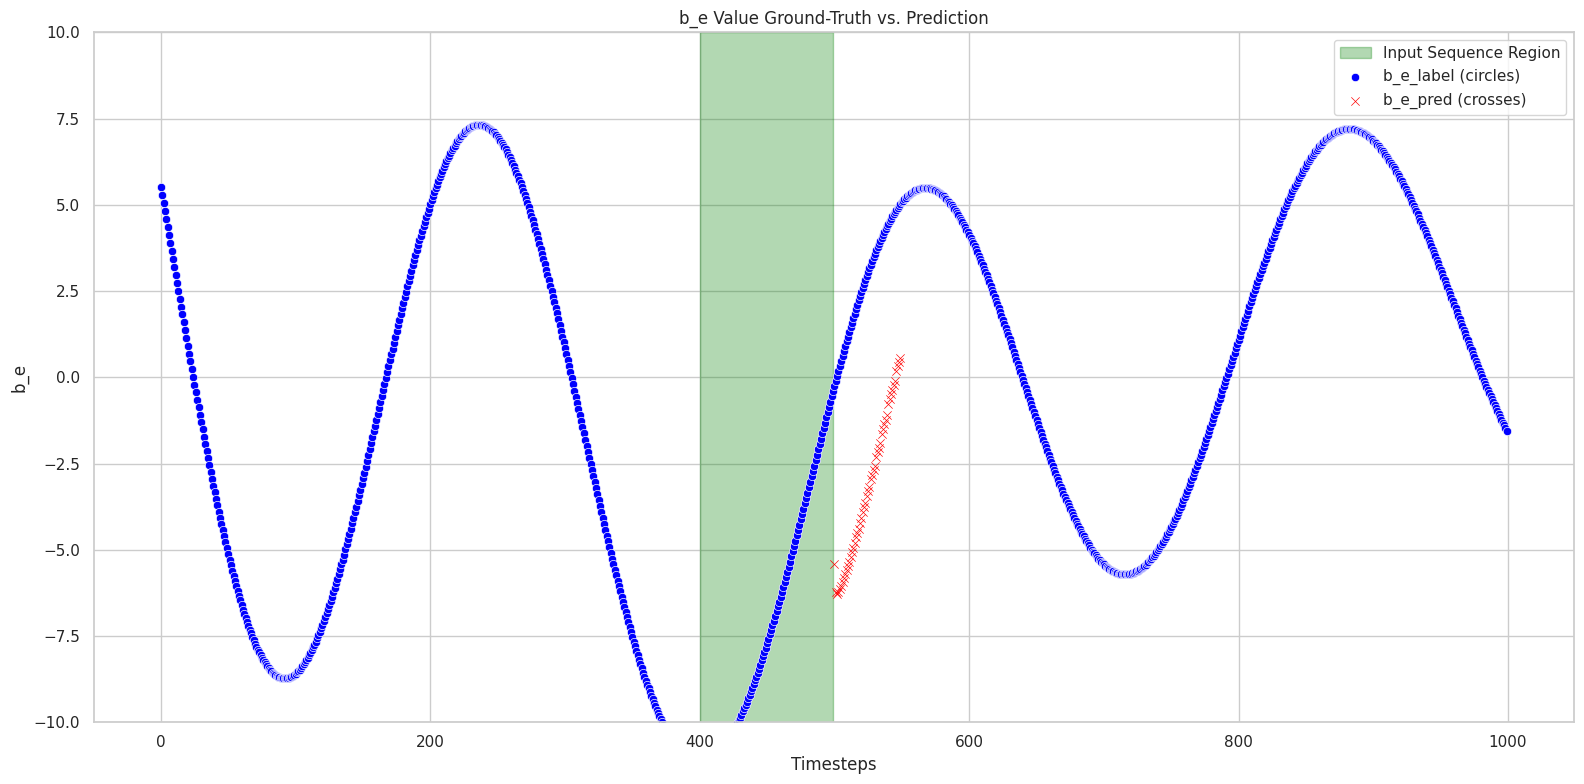

104it [00:05, 16.91it/s, single_test_loss=0.007546]

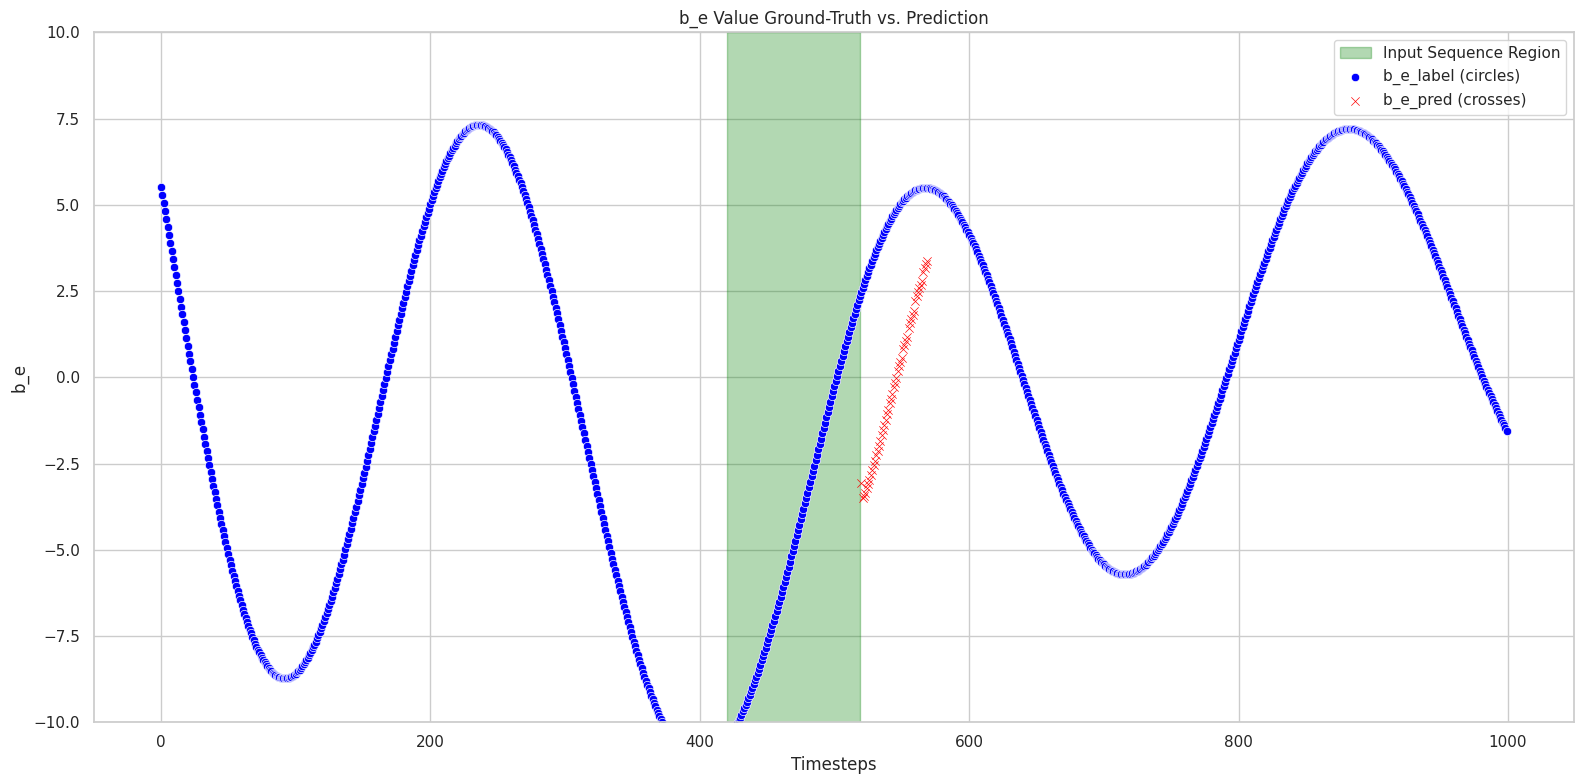

104it [00:05, 16.91it/s, single_test_loss=0.009971]

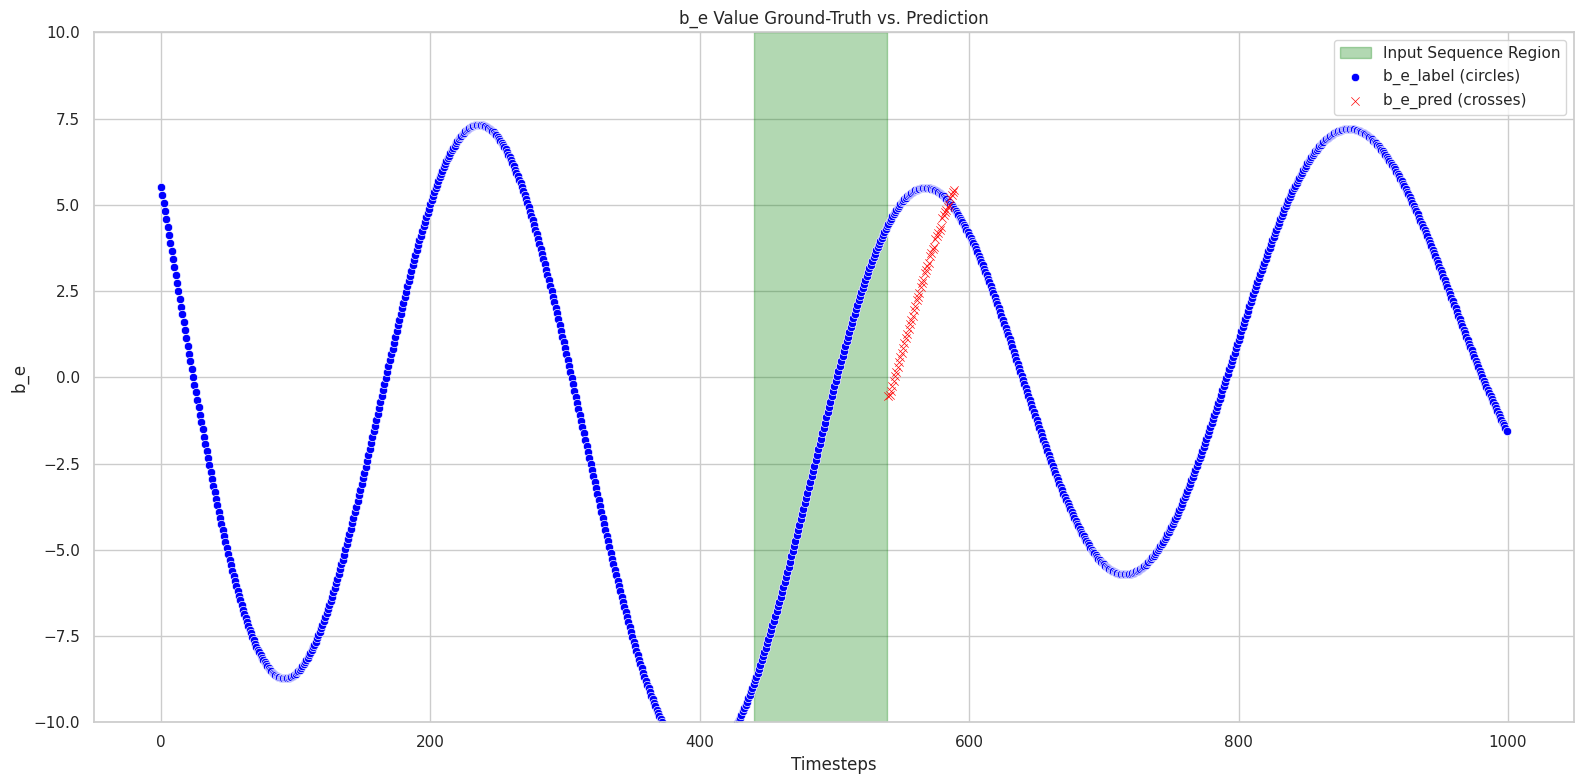

104it [00:05, 16.91it/s, single_test_loss=0.012592]

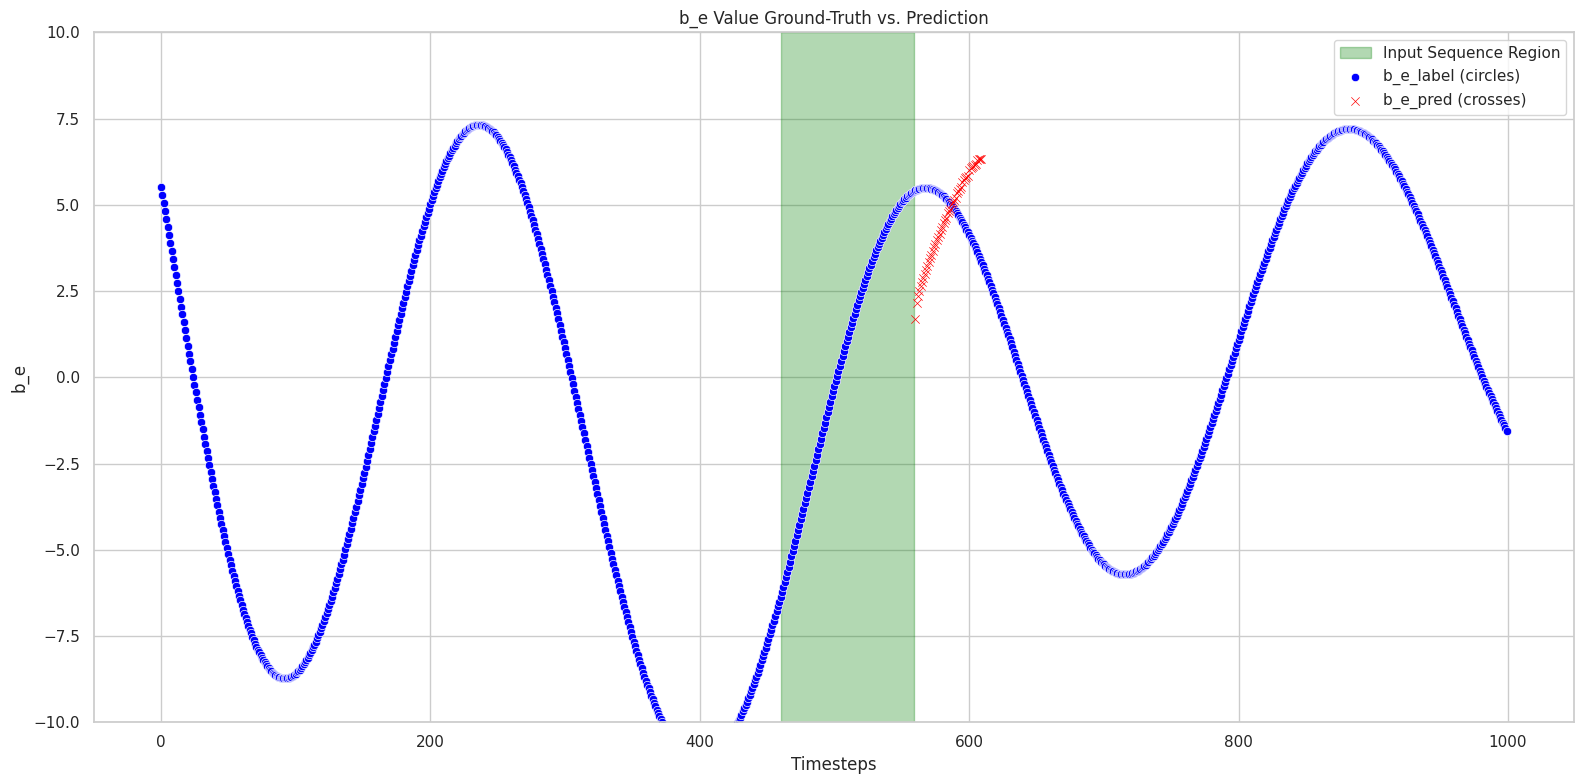

104it [00:05, 16.91it/s, single_test_loss=0.011777]

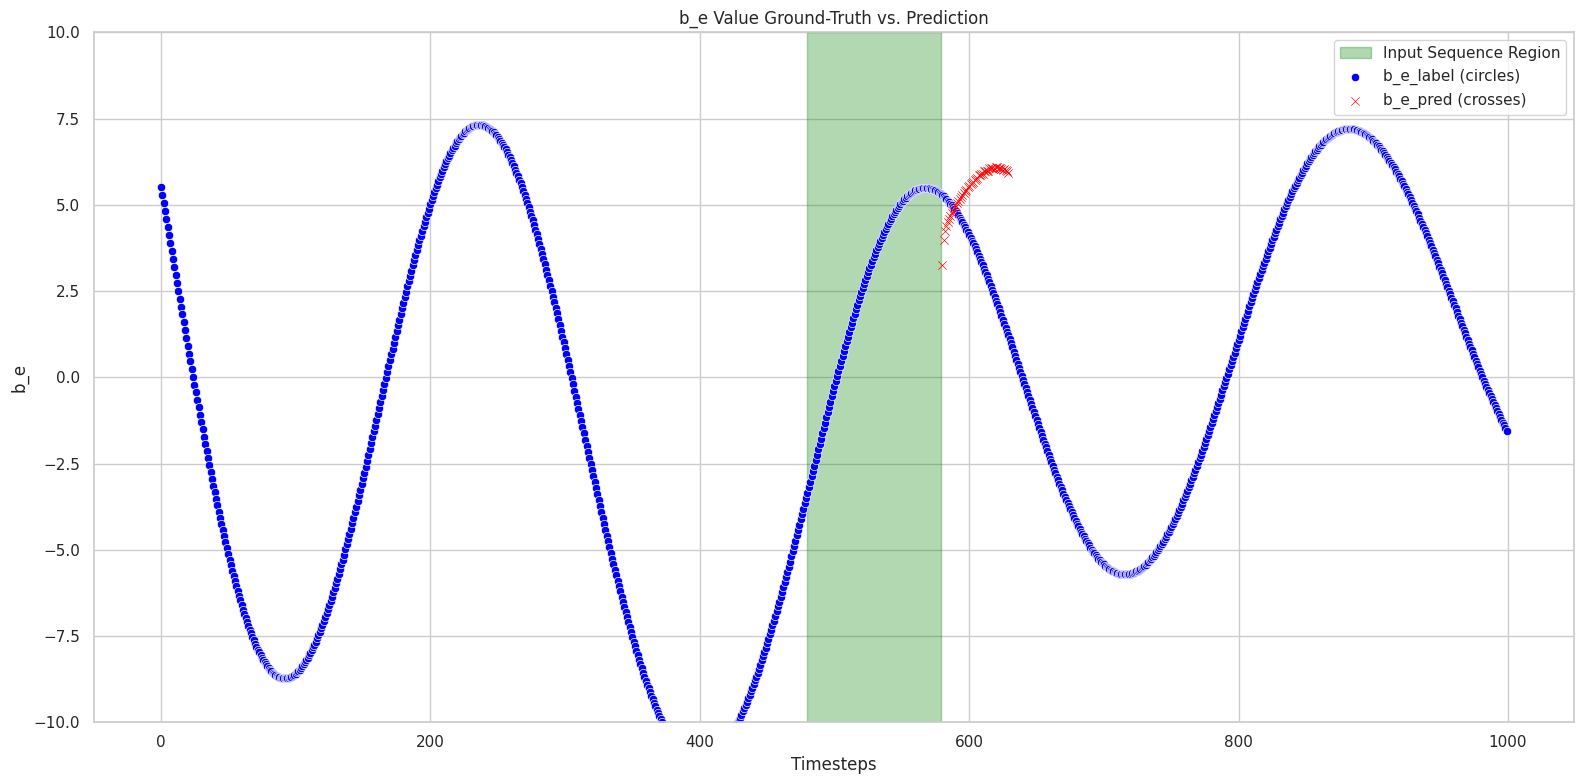

104it [00:06, 16.91it/s, single_test_loss=0.009460]

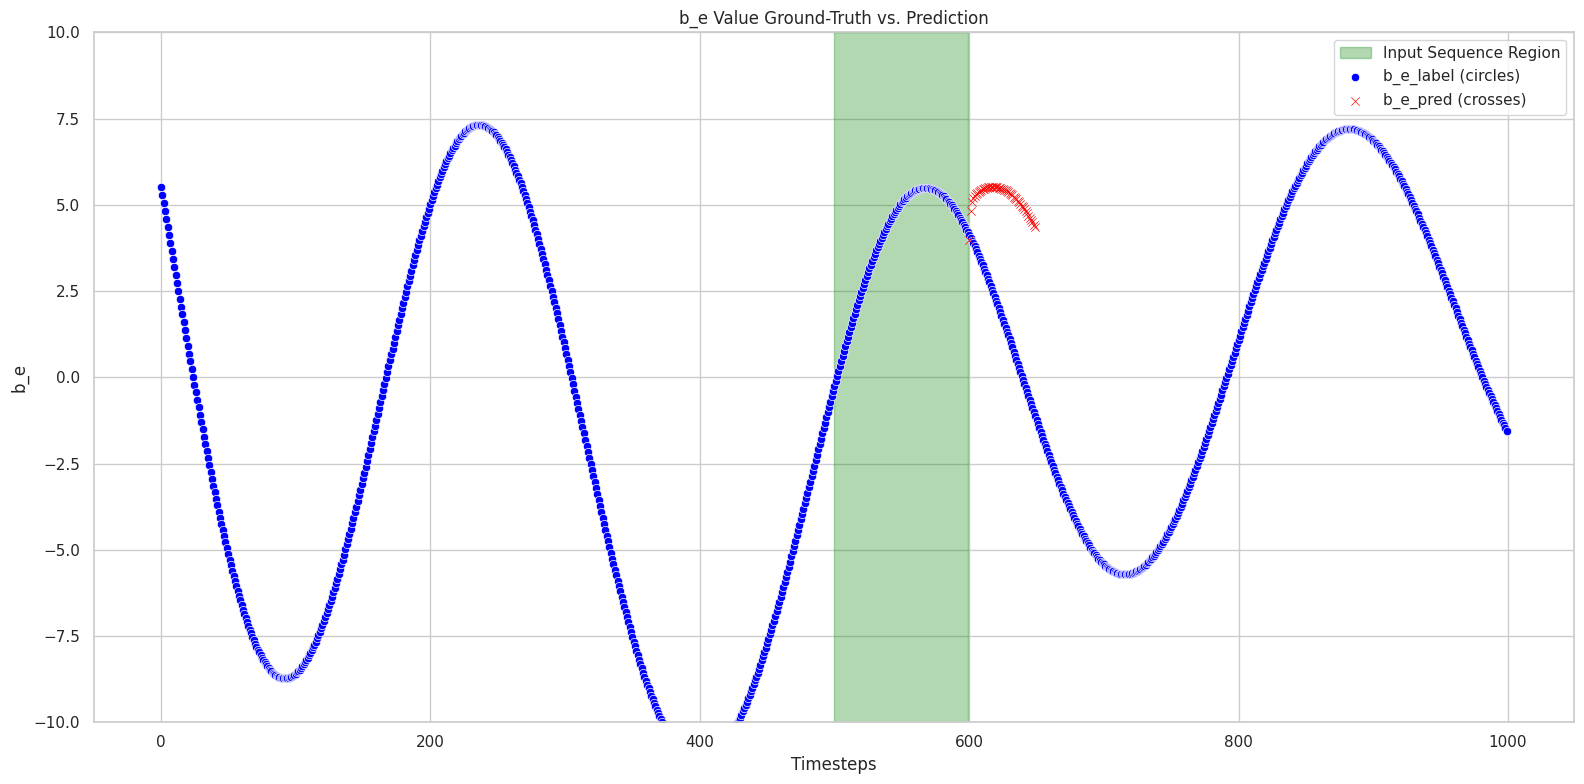

104it [00:06, 16.91it/s, single_test_loss=0.008671]

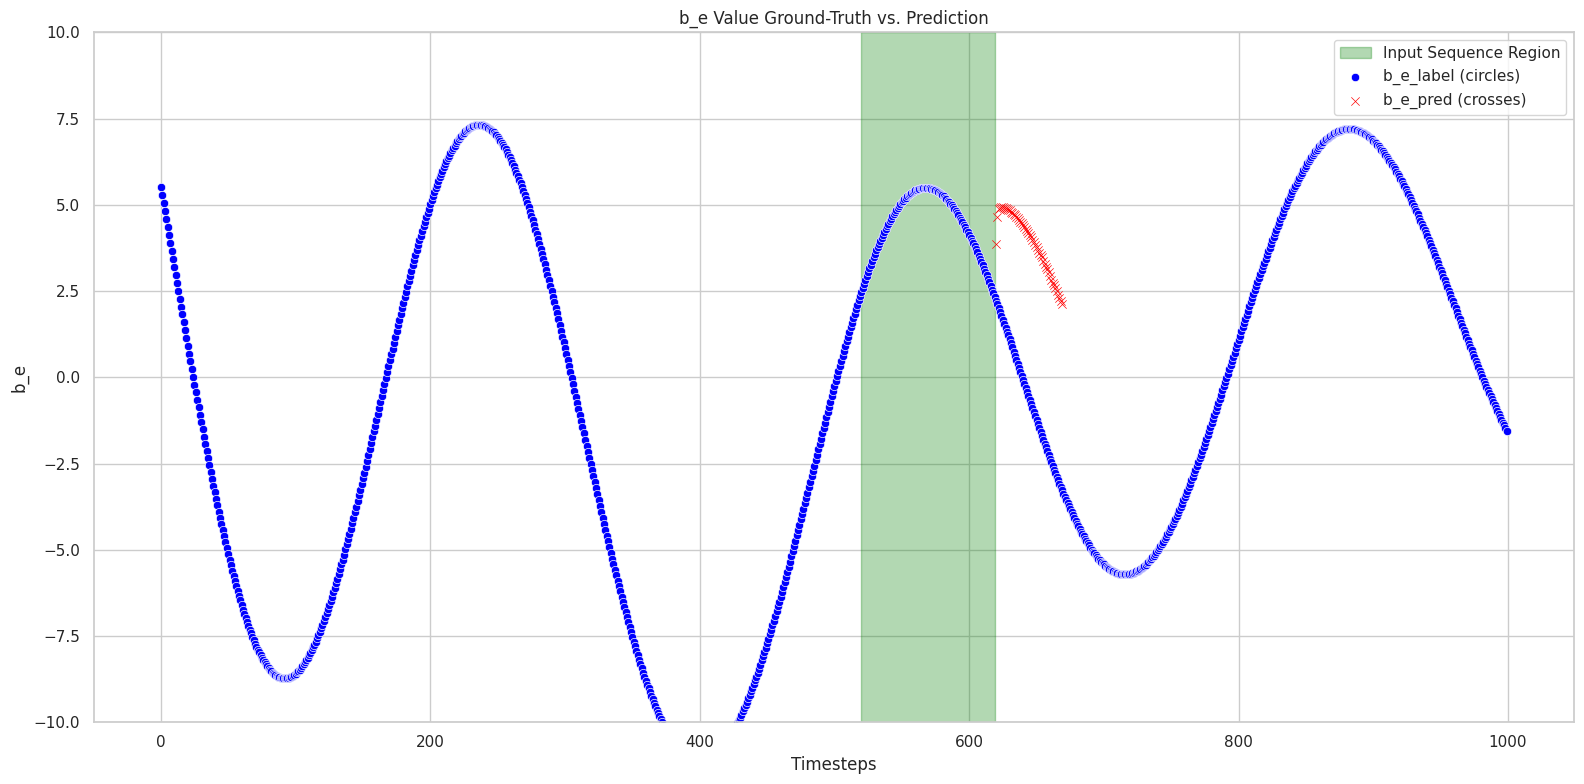

104it [00:06, 16.91it/s, single_test_loss=0.008072]

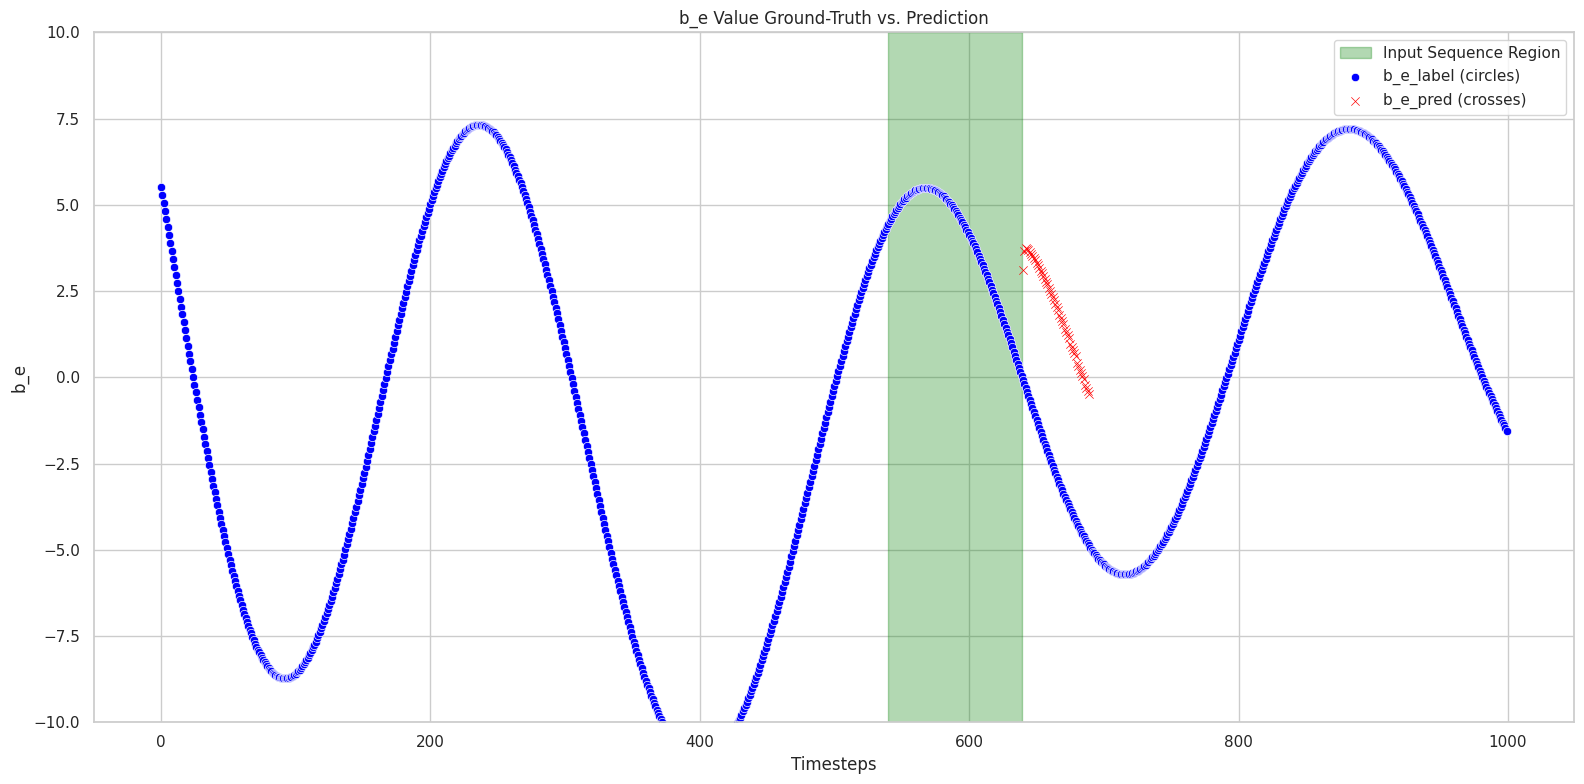

112it [00:06, 12.10it/s, single_test_loss=0.008831]

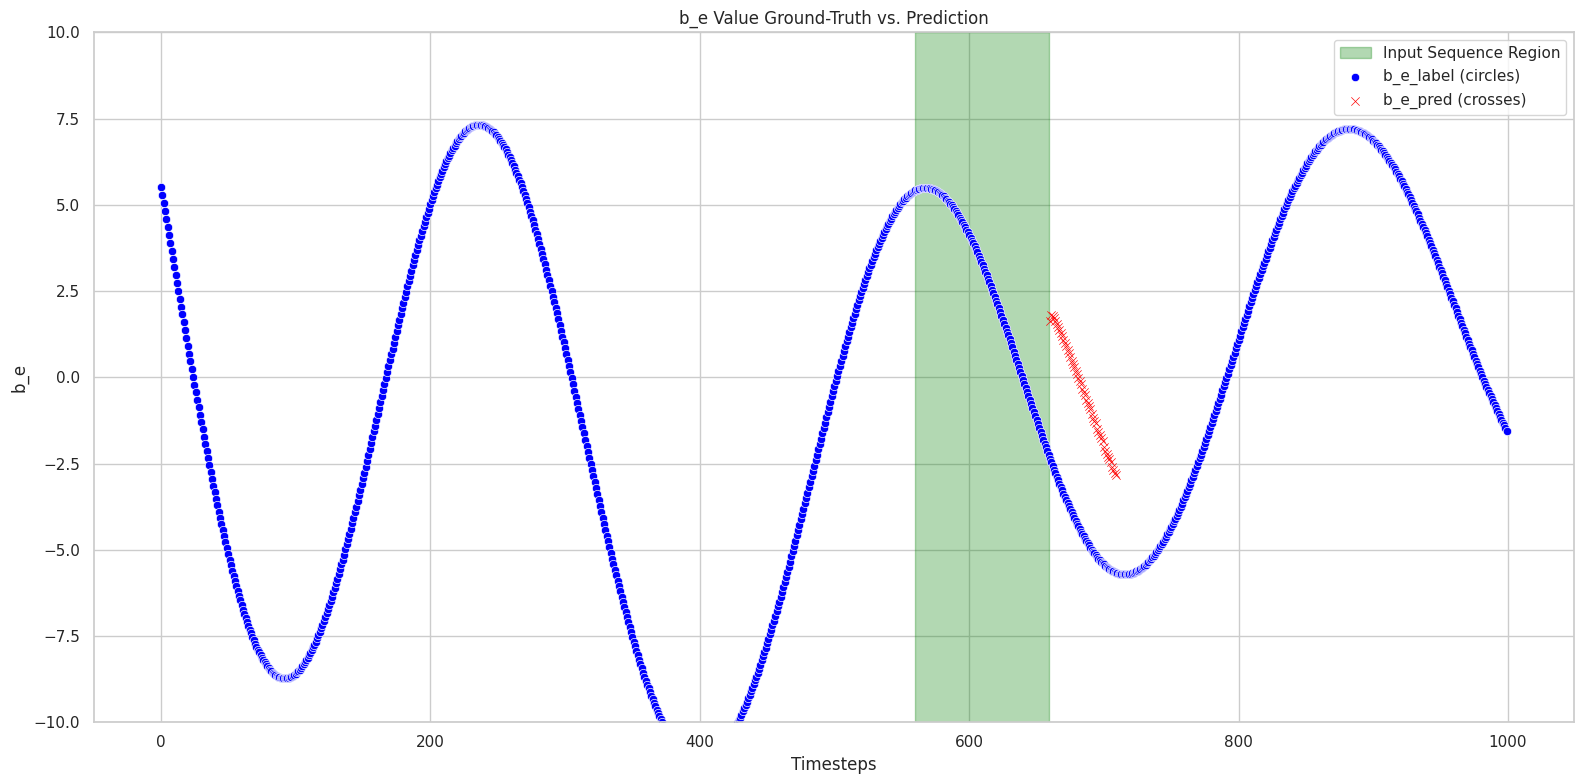

112it [00:07, 12.10it/s, single_test_loss=0.009415]

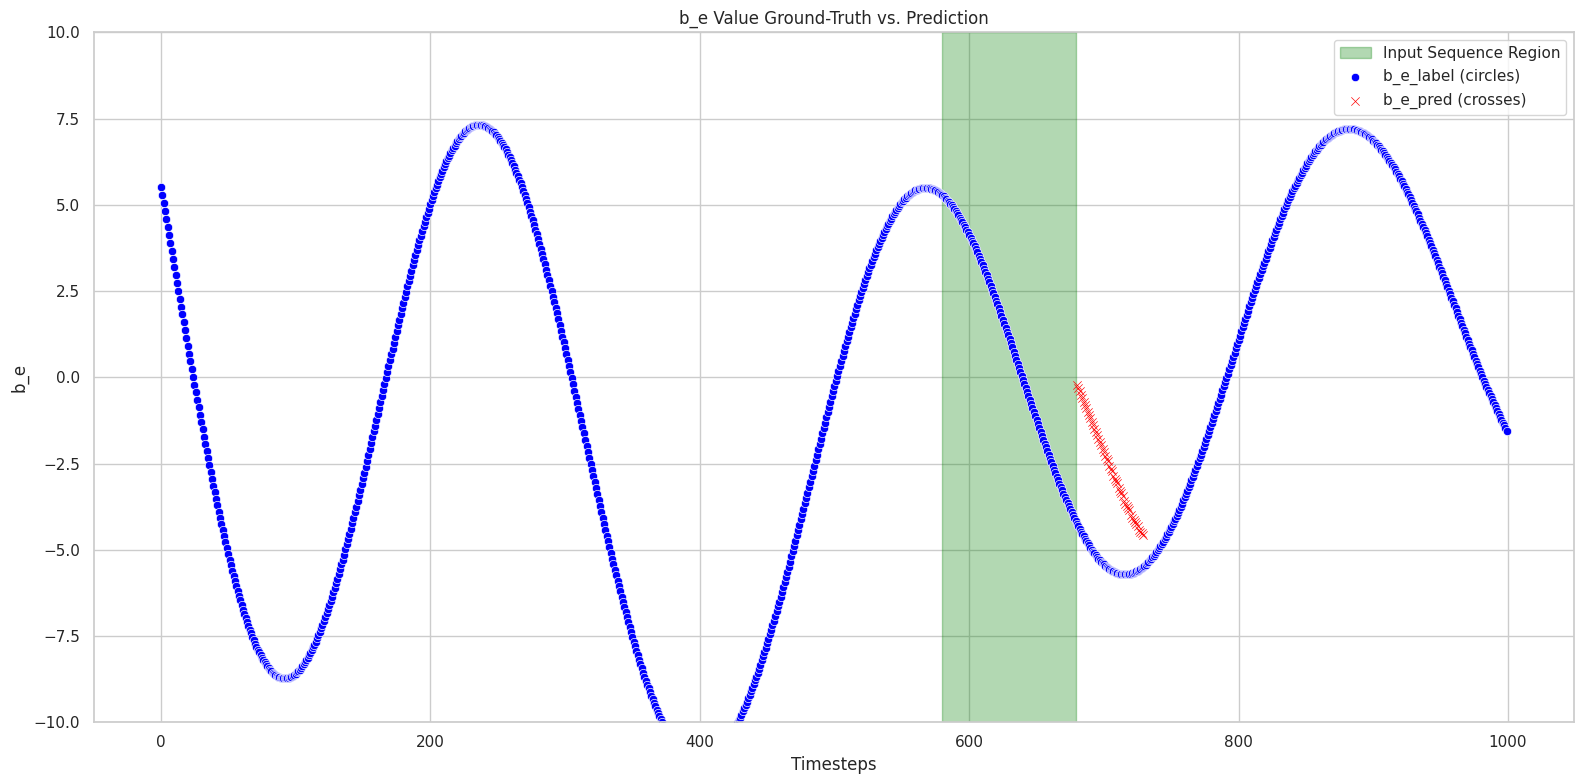

112it [00:07, 12.10it/s, single_test_loss=0.009692]

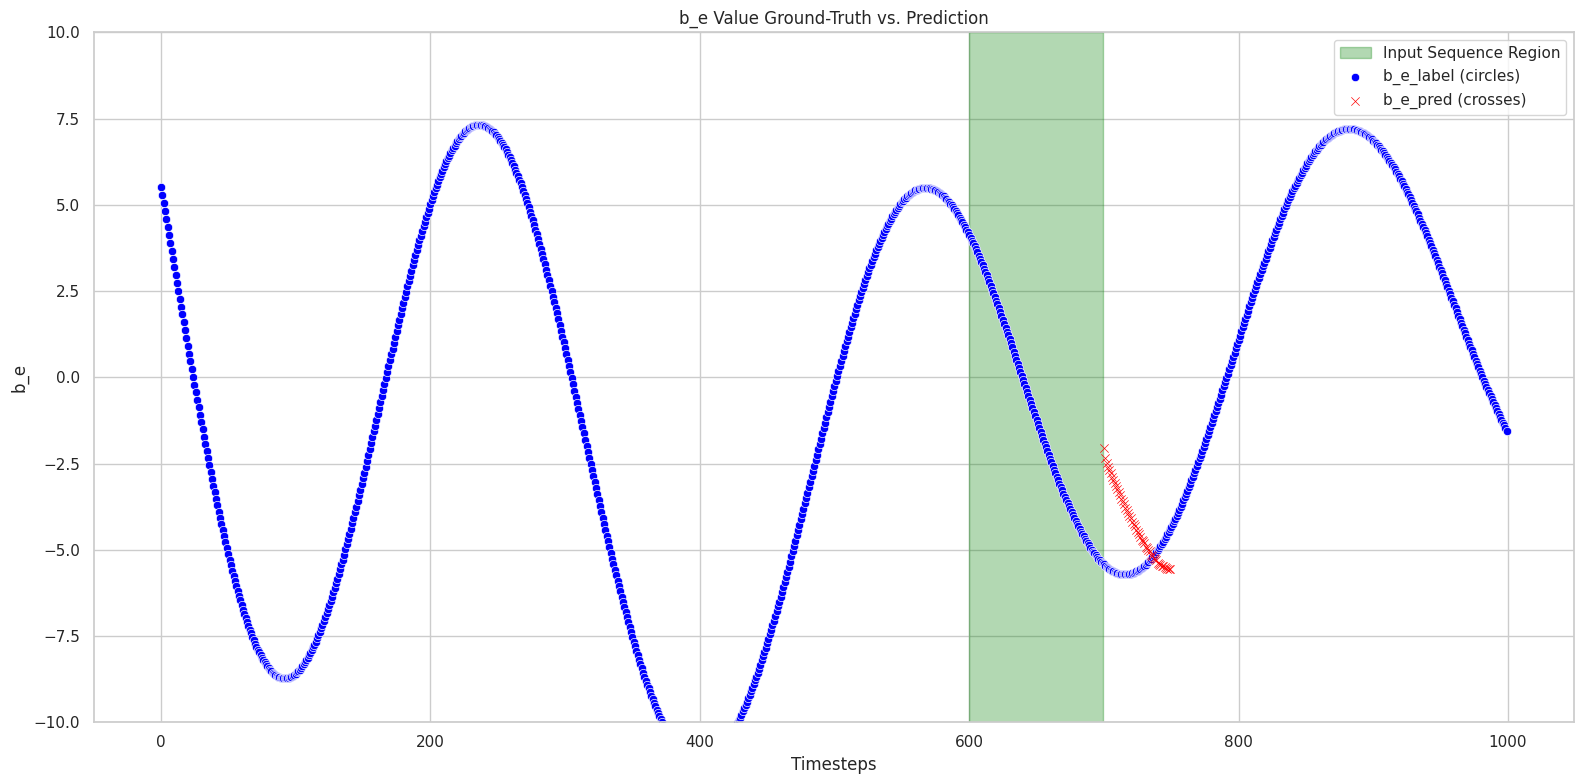

112it [00:07, 12.10it/s, single_test_loss=0.009217]

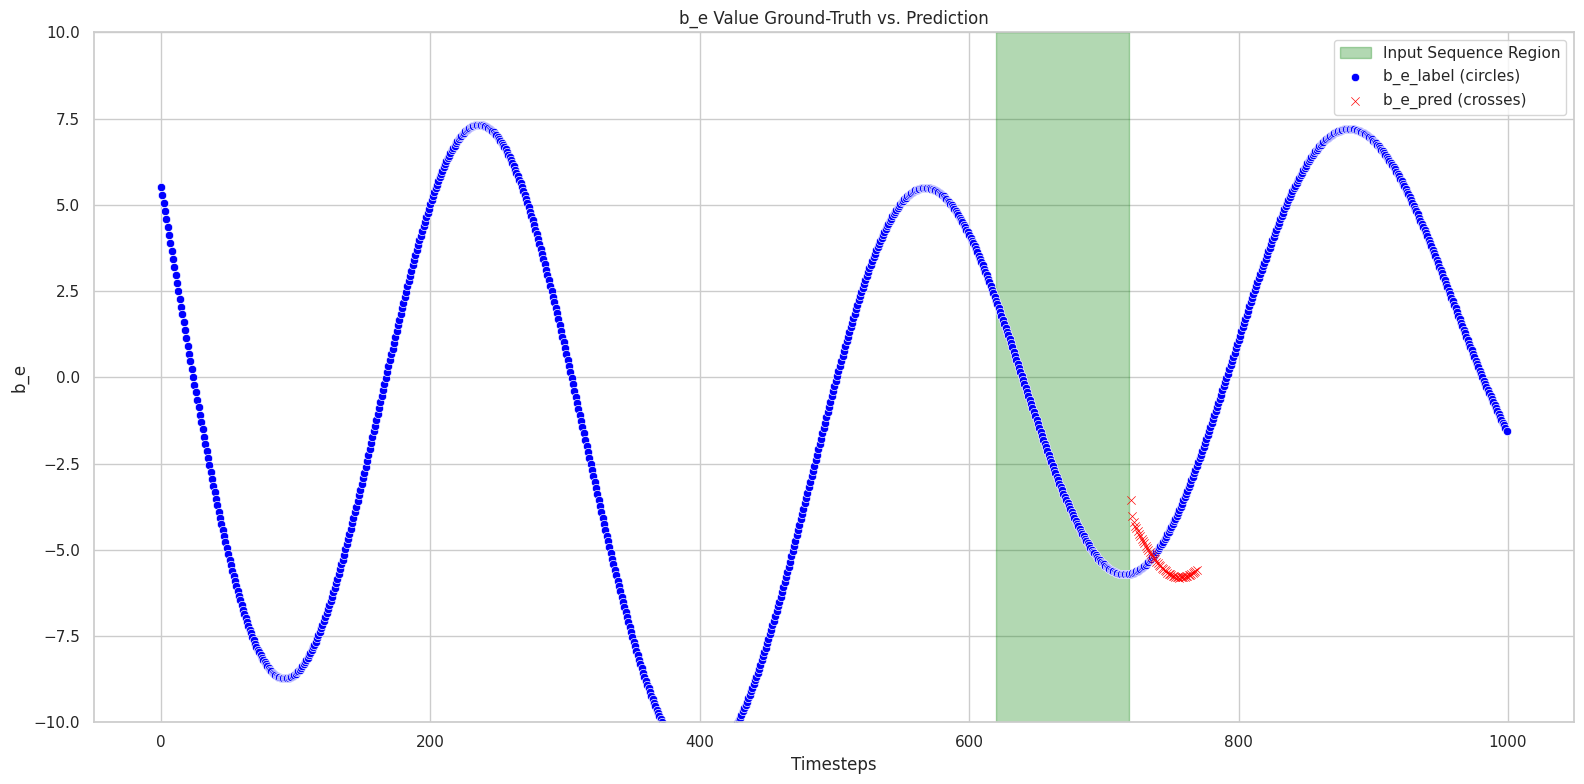

112it [00:07, 12.10it/s, single_test_loss=0.007284]

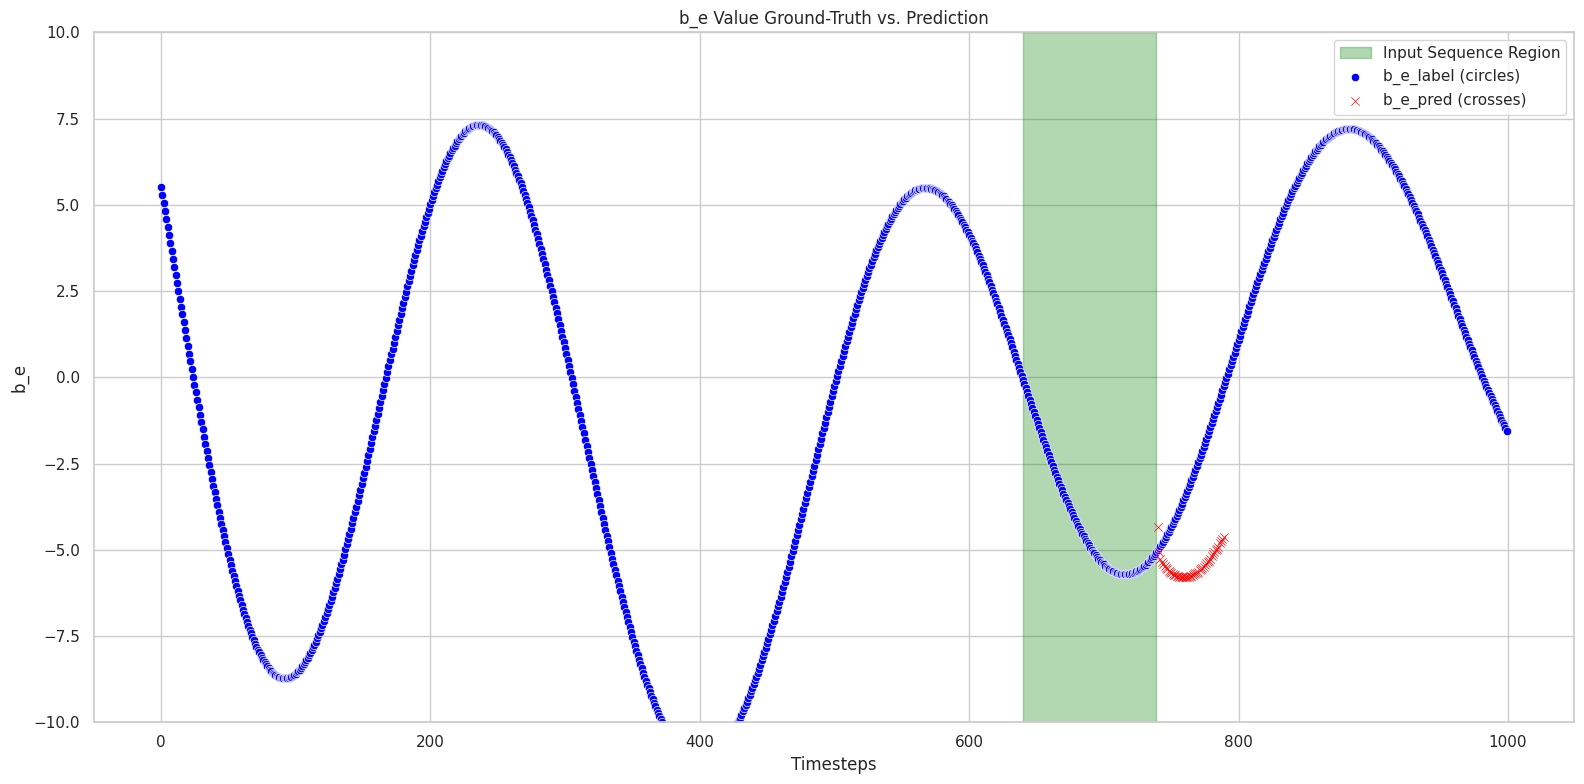

117it [00:07, 10.24it/s, single_test_loss=0.006176]

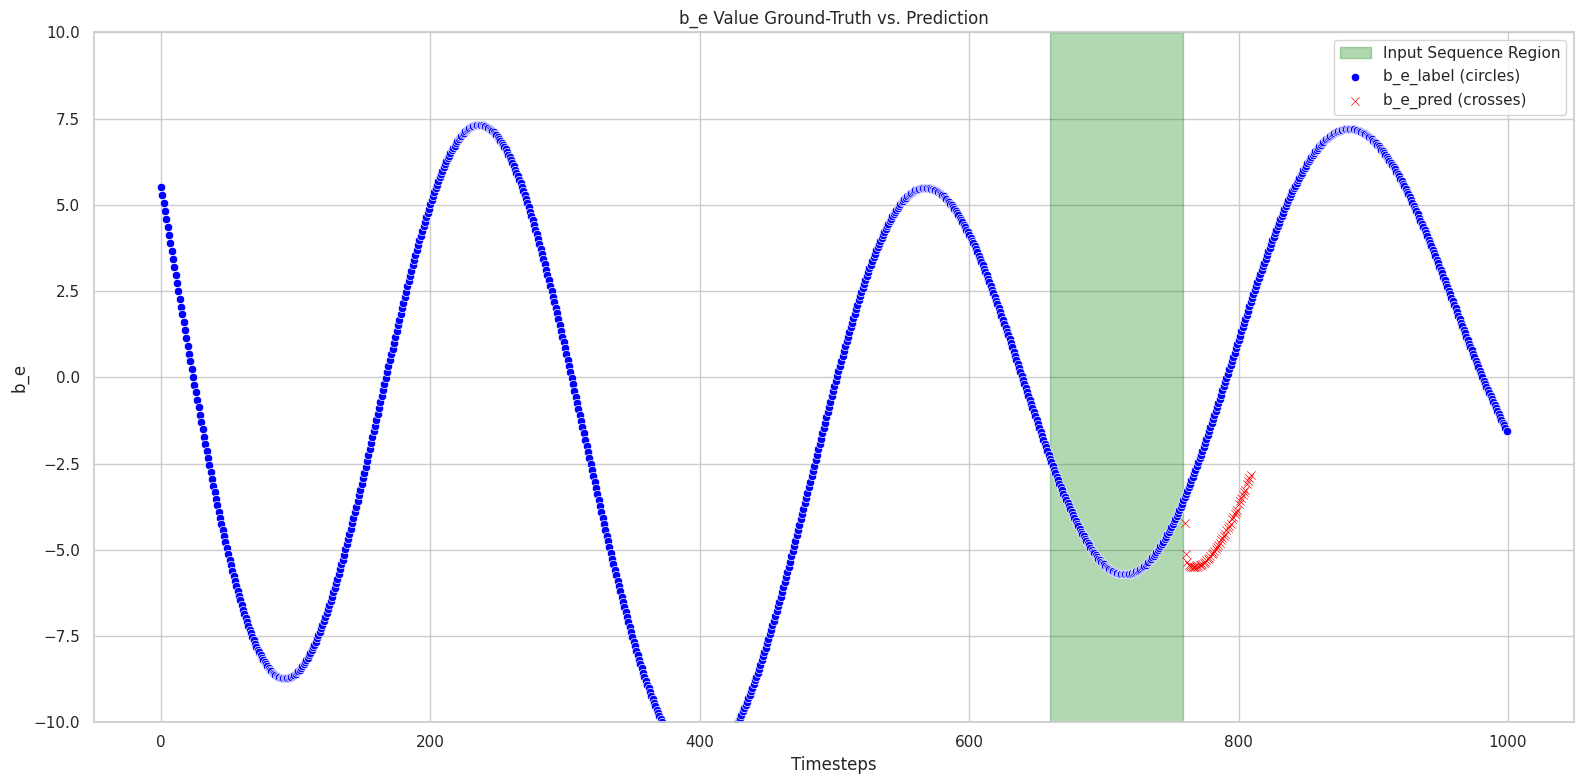

117it [00:08, 10.24it/s, single_test_loss=0.006500]

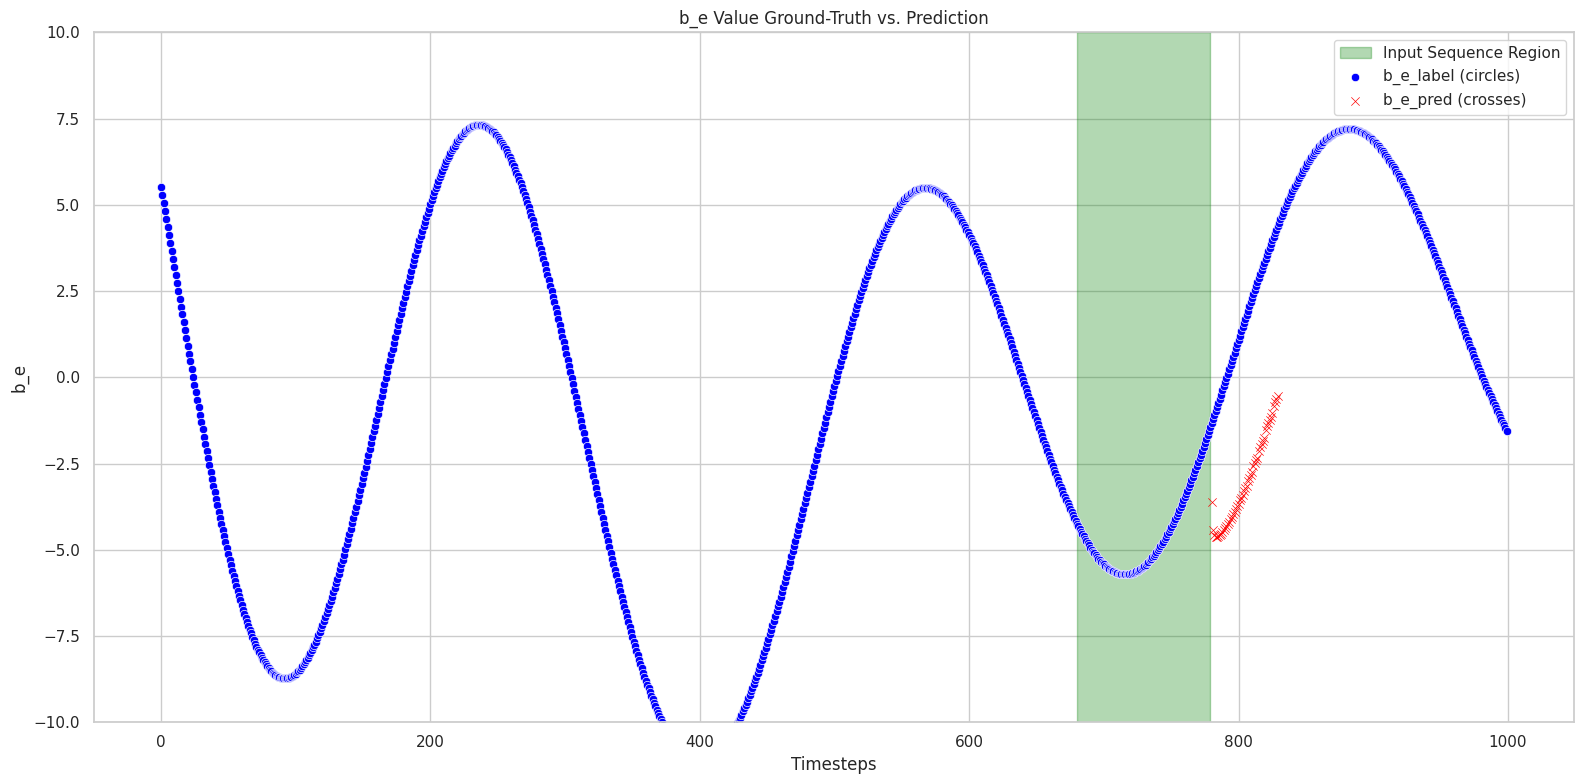

117it [00:08, 10.24it/s, single_test_loss=0.006867]

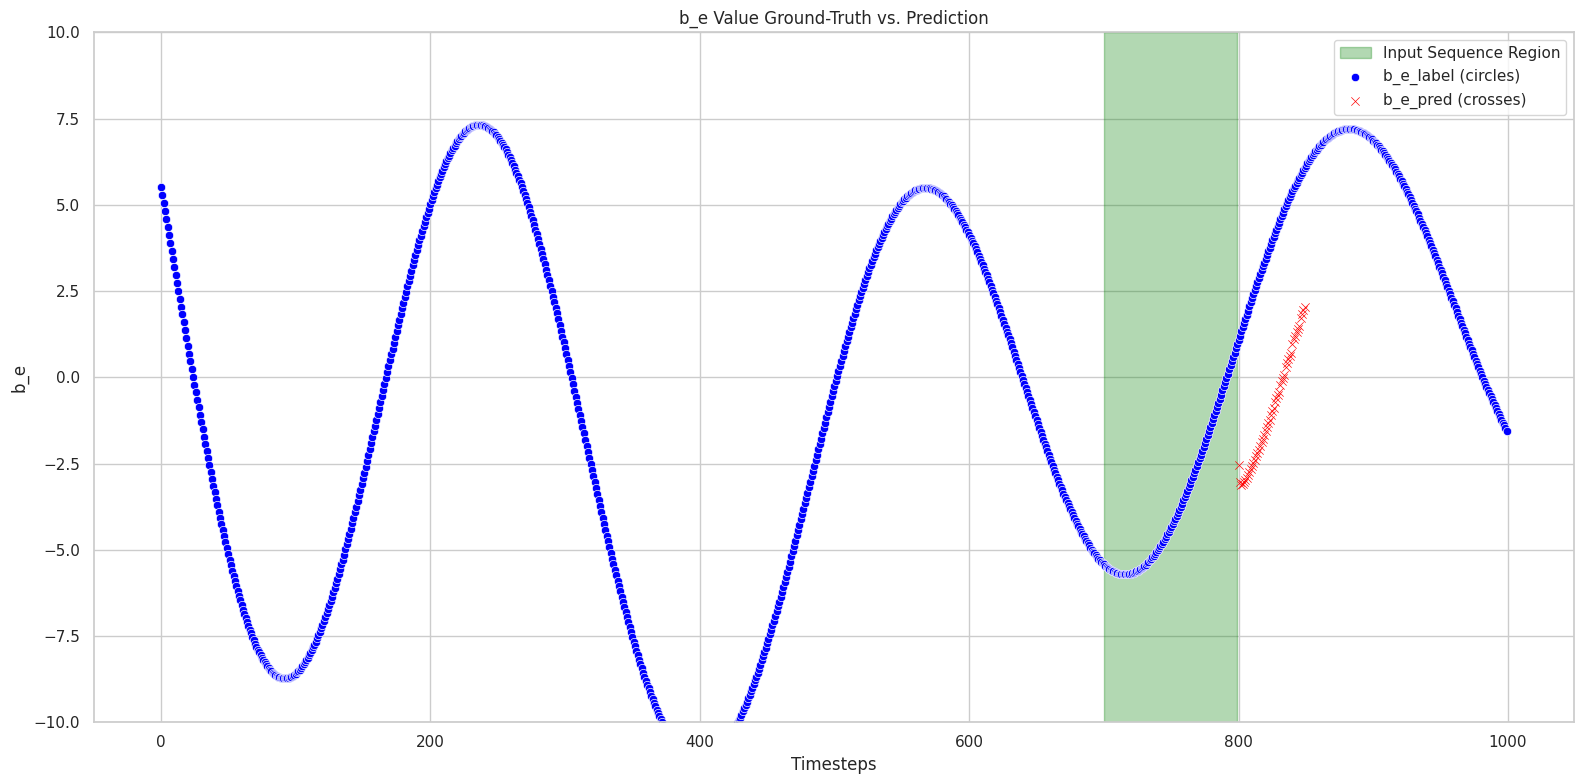

120it [00:08,  9.22it/s, single_test_loss=0.007416]

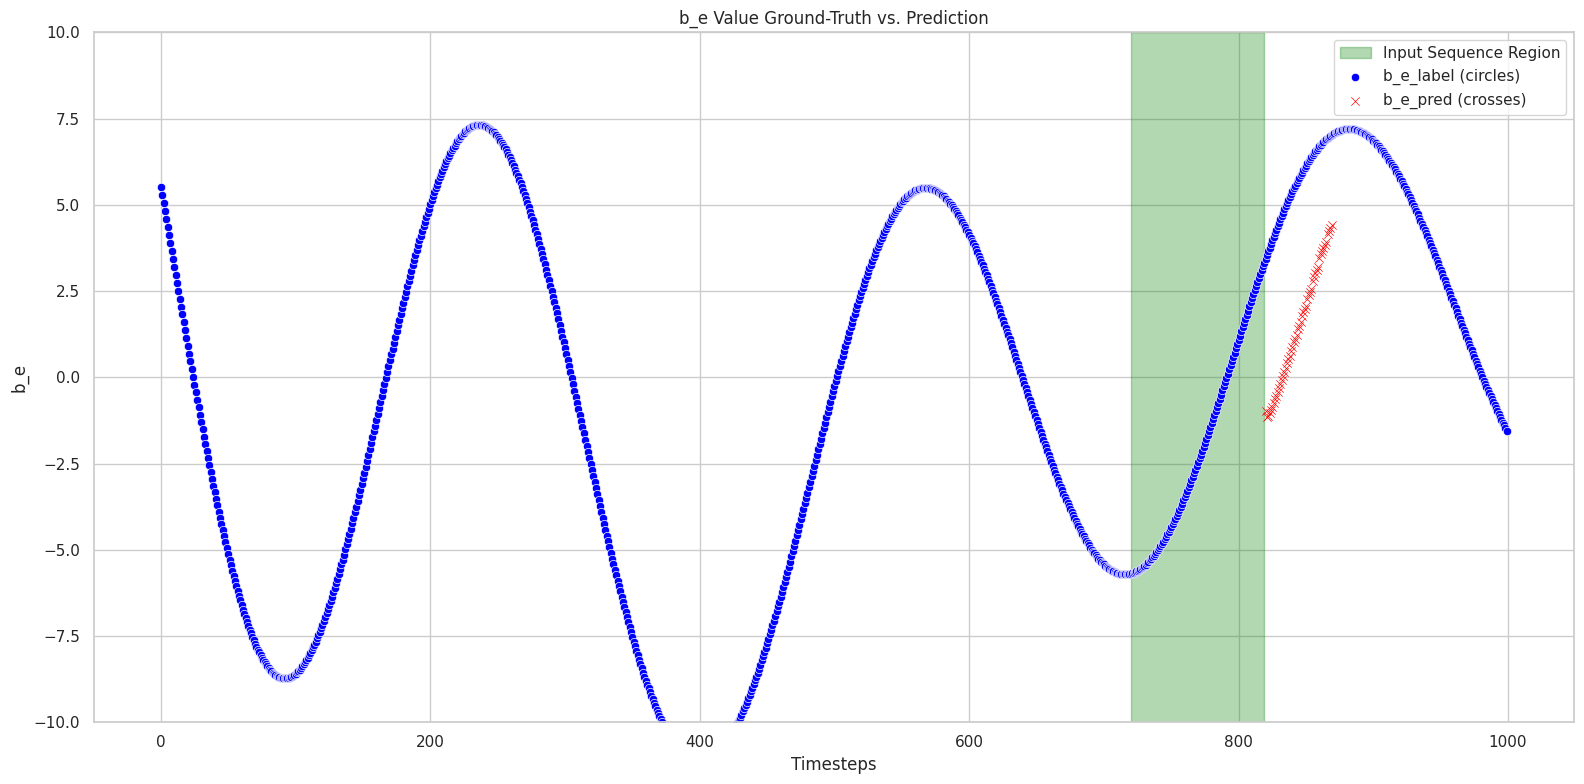

120it [00:08,  9.22it/s, single_test_loss=0.007784]

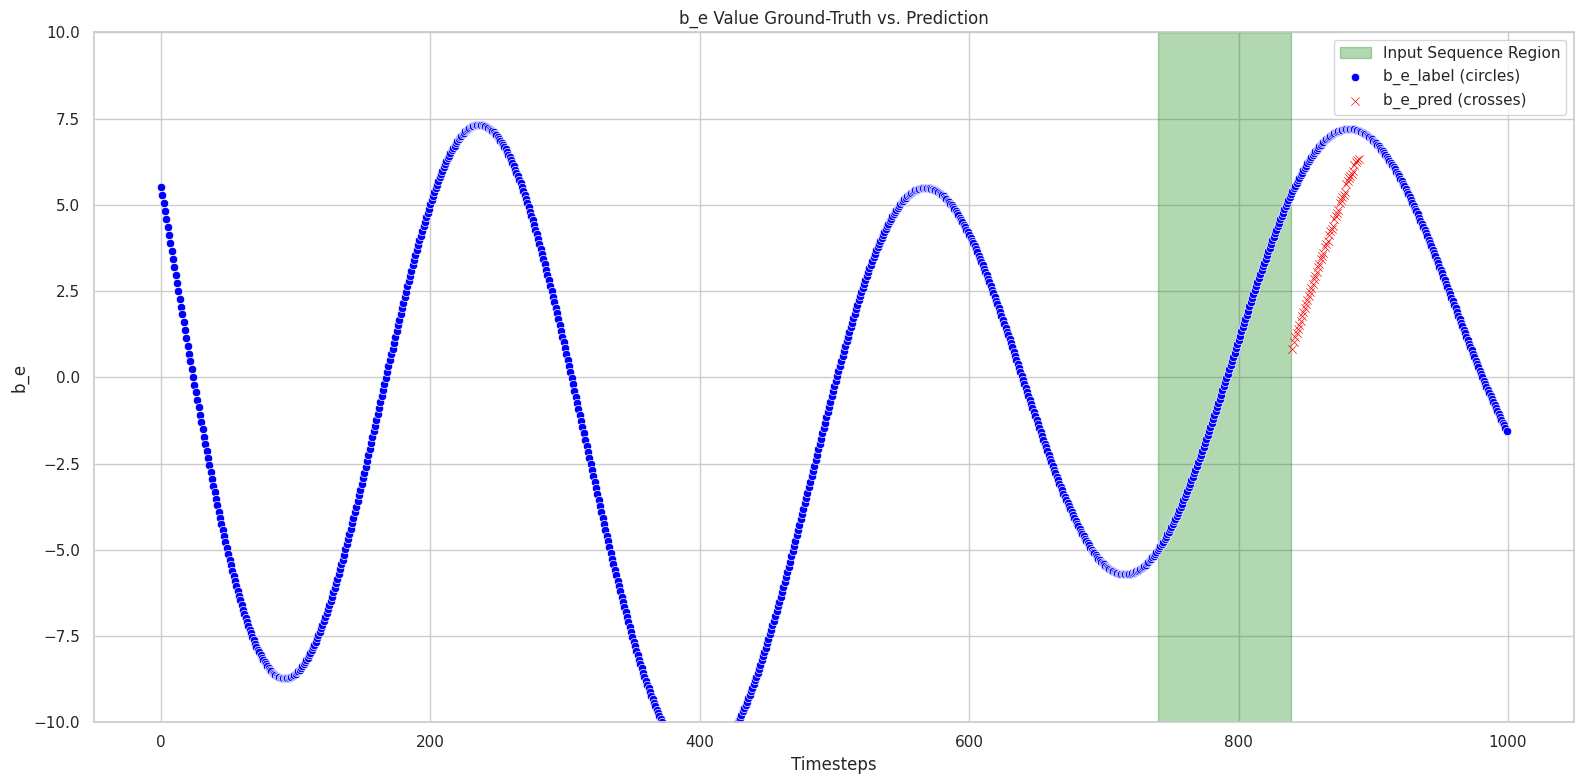

120it [00:09,  9.22it/s, single_test_loss=0.007660]

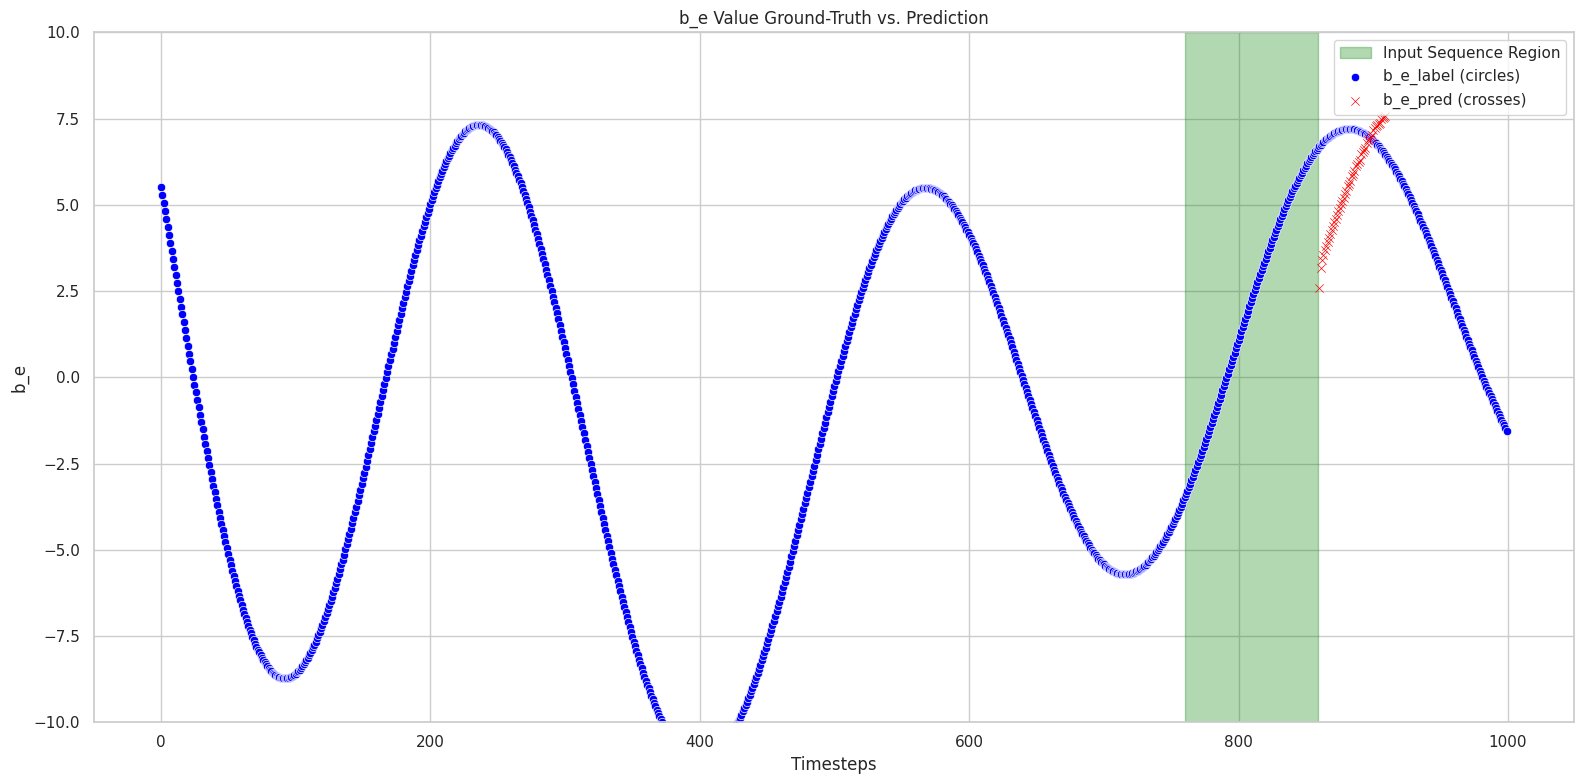

123it [00:09,  8.29it/s, single_test_loss=0.006824]

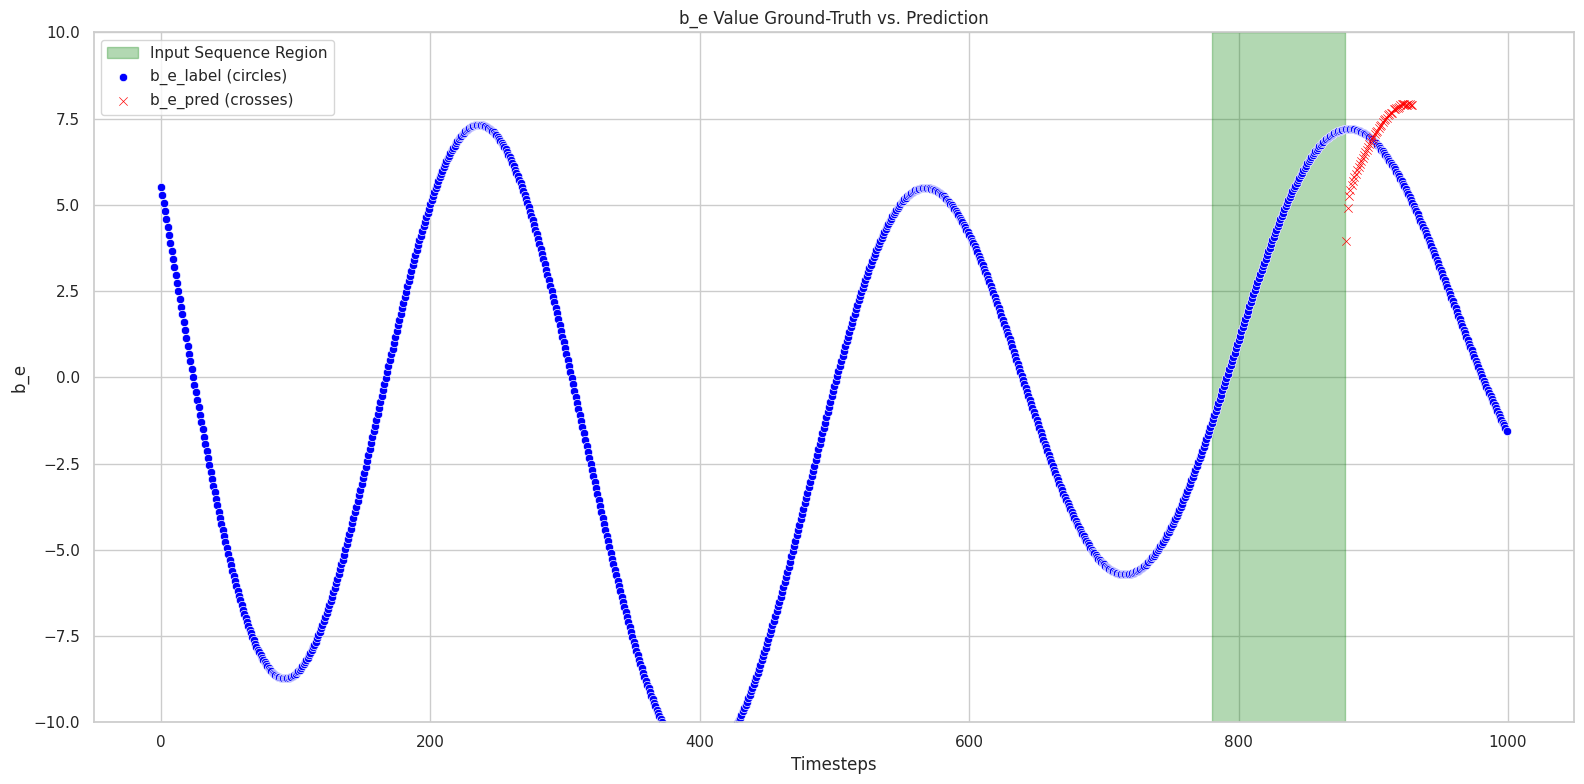

123it [00:09,  8.29it/s, single_test_loss=0.006536]

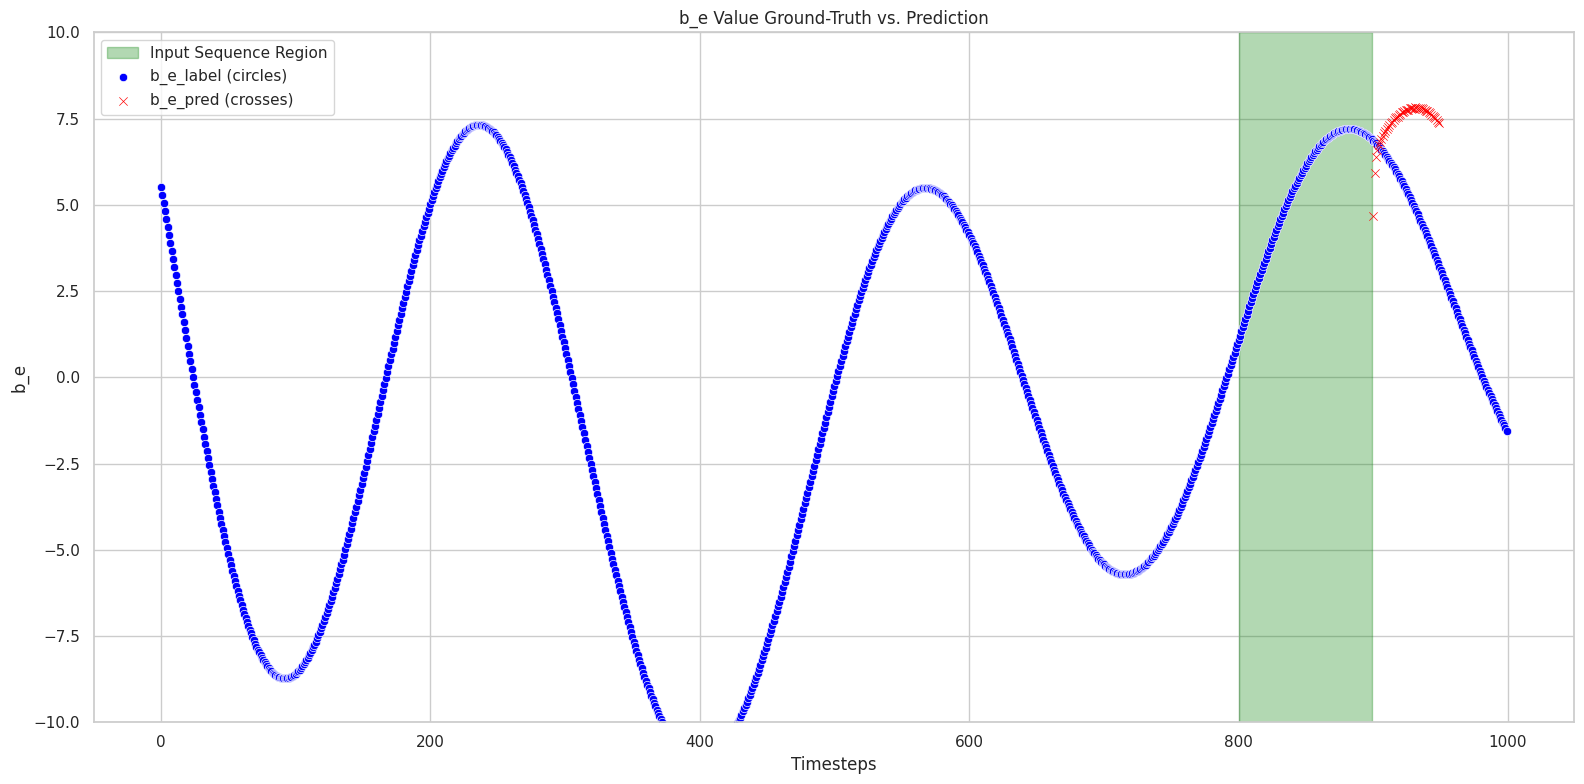

125it [00:09,  7.65it/s, single_test_loss=0.006053]

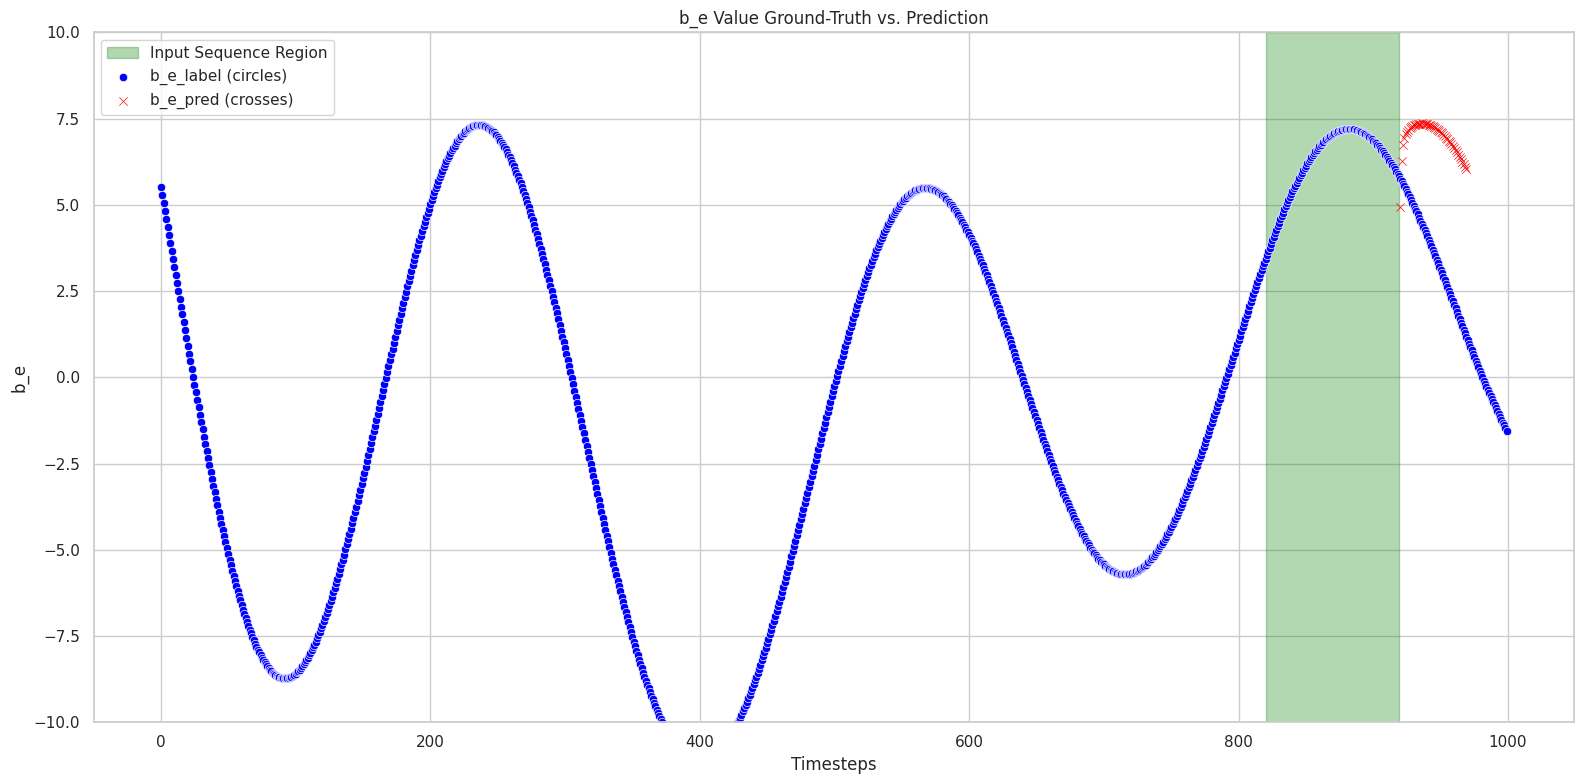

210915it [00:23, 9143.16it/s, single_test_loss=0.006053] 


In [9]:
test_loss = 0.0
test_progress_bar = tqdm(
    data_loader_test
)

criterion = torch.nn.MSELoss()

target_timeseries_idx = 2
feature = "b_e"
figure_range = 10

num_datapoints_per_timeseries = (num_single_sample_timesteps - (input_window_length + label_window_length) + 1) // window_stride

with torch.no_grad():
    for datapoint_idx, (batch_x, batch_y, x_labels) in enumerate(test_progress_bar):
        if(datapoint_idx >= target_timeseries_idx * num_datapoints_per_timeseries and datapoint_idx < (target_timeseries_idx + 1) * num_datapoints_per_timeseries):
            window_idx = datapoint_idx % num_datapoints_per_timeseries
            # Since we are not using batches we have to expand first dim so that one data point is considered a batch of size 1
            # Everything expects batches! --> unsqueeze(0) is like expand_dims(axis = 0)
            batch_x = batch_x.unsqueeze(0).to(device)
            batch_y = batch_y.unsqueeze(0).to(device)

            preds = autoregress(
                model = model,
                batch_x = batch_x,
                batch_y = batch_y,
                device = device
            )
            
            loss = criterion(preds, batch_y)
            test_progress_bar.set_postfix({
                "single_test_loss": f"{loss.item():.6f}"
            })

            x = list(range(num_single_sample_timesteps))

            feature_idx = label_features.index(feature)

            feature_label = batch_y[:, :, feature_idx].cpu()[0]
            feature_pred = preds[:, :, feature_idx].cpu()[0]
            feature_x_labels = x_labels[:, feature_idx]

            feature_pred = (feature_pred * stats["std"][feature]) + stats["mean"][feature]
            feature_label = (feature_label * stats["std"][feature]) + stats["mean"][feature]
            feature_x_labels = (feature_x_labels * stats["std"][feature]) + stats["mean"][feature]

            sns.set_theme(style = "whitegrid")
            fig, ax = plt.subplots(figsize = (16, 8))
            ax.set_ylim(-figure_range, figure_range)

            ax.axvspan(
                x[window_idx * window_stride],
                x[window_idx * window_stride + input_window_length - 1],
                color = "green",
                alpha = 0.3,
                label = "Input Sequence Region"
            )

            sns.scatterplot(
                x = x,
                y = feature_x_labels,
                marker = "o",
                label = f"{feature}_label (circles)",
                color = "blue",
                ax = ax
            )
            # sns.scatterplot(
            #     x = x[(input_window_length + plot_counter):],
            #     y = u_label,
            #     marker = "o",
            #     color = "blue",
            #     ax = ax
            # )
            sns.scatterplot(
                x = x[(input_window_length + window_idx * window_stride):(input_window_length + window_idx * window_stride + label_window_length)],
                y = feature_pred,
                marker = "x",
                label = f"{feature}_pred (crosses)",
                color = "red",
                ax = ax
            )

            ax.set_title(f"{feature} Value Ground-Truth vs. Prediction")
            ax.set_xlabel("Timesteps")
            ax.set_ylabel(feature)
            ax.legend()

            plt.tight_layout()
            plt.show()

            # last_decoder_layer_shared_attention = model.attention_weights["cross_attention"][-1][0]
            # avg_attention_weights = last_decoder_layer_shared_attention.mean(dim = 0).cpu().numpy()

            # for i in range(20):     # First 20 predictions following input sequence 
            #     output_row = avg_attention_weights[i, :]
            #     top_k_indices = np.argsort(output_row)[::-1][:10]    # Top 10 highest attention input timesteps
            #     top_k_scores = output_row[top_k_indices]
            #     print(f"Output Timestep {plot_counter + input_window_length + i + 1}: Input Timesteps {top_k_indices + plot_counter + 1} with scores {[f'{score:.5f}' for score in top_k_scores]}")


# There are issues with the indexing still, It's not correctly finding the target time-series